# <img style="float: left; padding-right: 20px; width: 200px" src="https://raw.githubusercontent.com/raxlab/imt2200-data/main/media/logo.jpg">  IMT 2200 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Instituto de Ingeniería Matemática y Computacional**<br>
**Profesor:** Rodrigo A. Carrasco <br>
**Integrantes:**
- Bárbara Canales
- Giuliana Tirachini
- Benjamin Cheuquian
- Mark von Riegen
- Felipe Villavicencio
---

#### Proyecto:

# Desafíos del Sistema de Salud Pública en Chile: Un Análisis de Fonasa y la Demanda por Servicios de Atención Médica:

## **I - Introducción**

### **Contexto y motivacion**

Elegimos hacer el proyecto sobre Fonasa porque consideramos que los recursos podrían ser mejor administrados en las instituciones de salud pública, enfocándonos en las áreas que más lo requieren. En un contexto donde la demanda por atención médica ha aumentado, especialmente en ciertas especialidades y servicios, es fundamental redistribuir los recursos para garantizar un acceso adecuado y oportuno a la atención.  

Nuestra motivación surge de la evidencia que indica que hay áreas específicas de la atención primaria, exámenes de diagnóstico y consultas especializadas, que enfrentan una alta demanda y, a menudo, carecen de los recursos necesarios para atender a la población de manera efectiva. Investigaciones recientes muestran que muchas personas enfrentan largas esperas o dificultades para acceder a estos servicios esenciales, lo que puede tener un impacto negativo en su salud.  

Al analizar el sistema de Fonasa, buscamos identificar oportunidades para redirigir recursos hacia estas áreas críticas, asegurando que se satisfagan las necesidades más urgentes de la población. Fonasa se presenta como una muestra representativa de lo que necesitan las personas, reflejando las realidades y desafíos que enfrentan en su búsqueda de atención médica. Este enfoque no solo mejoraría la atención médica, sino que también optimizaría el uso de los recursos disponibles.  

La audiencia objetivo de nuestro análisis incluye a tomadores de decisiones en el ámbito de la salud pública, como entidades del Ministerio de Salud y administradores de los centros públicos. Nuestro trabajo servirá como una herramienta valiosa para informar políticas que prioricen el financiamiento en las áreas más solicitadas, promoviendo un sistema de salud más equitativo y eficaz.


### **Objetivos**
**Científicos y de inferencia:**  
Identificar patrones y correlaciones entre factores demográficos, socioeconómicos y geográficos relacionados con las necesidades de atención médica de los beneficiarios de FONASA.


**Preguntas clave**  
¿Cómo varían las necesidades de atención médica y su coste en el sistema de salud público según factores demográficos, socioeconómicos y geográficos?

**Beneficios accionables** -> Optimización de recursos:  
Redirigir recursos hacia áreas más demandadas según la estacionalidad y tendencias demográficas.
Mantener el equilibrio para no descuidar áreas de menor demanda.
Focalizar esfuerzos en necesidades recurrentes o menos cubiertas para garantizar una atención más eficiente y equitativa.

**Audiencia objetivo**  
Ministerio de Salud: Para informar decisiones estratégicas de política pública.  
Administradores de centros de salud pública: Para optimizar la asignación de recursos y mejorar la atención a la población.

### **Datos y variables**

A continuación, se detalla la estructura y relevancia de las fuentes de datos utilizadas:  

**Población Beneficiaria Diciembre 2023 (Fonasa) (`beneficiarios_df`)**  

Descripción: Este conjunto de datos contiene información demográfica detallada sobre los beneficiarios de Fonasa en 2023.  

Variables Clave:  
SEXO: Género de los beneficiarios.  
EDAD_TRAMO: Rango etario.  
TITULAR_CARGA: Relación con el titular del sistema.  
NACIONALIDAD: Nacionalidad de los beneficiarios.  

Cobertura: Incluye datos de todas las regiones de Chile, con más de 10 millones de registros, permitiendo un análisis nacional y granular.  
Aplicaciones: Analizar la composición demográfica de los beneficiarios y su distribución geográfica.  



**Modalidad Libre Elección Diciembre 2023 ( `mle_2023_df`)**  

Descripción: Este conjunto de datos detalla el uso de prestaciones bajo la modalidad de libre elección en el sistema Fonasa.  

Variables Clave:  
MES_EMISION: Mes de emisión de la prestación.  
CODIGO_PRESTACION: Código asignado a cada tipo de prestación.  
DESC_SECCION: Descripción de la sección correspondiente.  
DESC_ITEM: Detalle del ítem relacionado con la prestación.  
REGION_EMISION / COMUNA_EMISION: Ubicación geográfica de la emisión.  

Aplicaciones: Estudio del acceso y uso de prestaciones por región y comuna, evaluando patrones y posibles desigualdades.  


**Tamaño y Accesibilidad**

Ambos conjuntos están disponibles en formato CSV desde el portal de Fonasa:   

https://www.fonasa.cl/sites/fonasa/datos-abiertos/estadisticas-anuales. 

Estos archivos, con un tamaño conjunto superior a 10 GB, aseguran un nivel de detalle elevado.



**Fuente de Datos Complementaria**

Además de las bases mencionadas, se dispone de un conjunto de datos adjunto que detalla los códigos de prestación, clave para interpretar los registros de la segunda fuente. Esto permitirá vincular el codigo de las prestaciones con sus nombres y aranceles.

Disponible en el siguiente link:   
(de todas maneras, el .xlsx original se encuentra en el resositorio)  

https://www.fonasa.cl/sites/fonasa/prestadores/modalidad-libre-eleccion#normativa-y-arancel-modalidad-libre-eleccin--mle-

---

**De todas maneras en cada pregunta segun sea pertinente se entrara en detalle de la variable y la razon de su eleccion.**  

---

### **Preguntas de investigación**  

**Pregunta general**   

**¿Cómo varían las necesidades de atención médica y el gasto asociado en la población chilena según factores demográficos, socioeconómicos y geográficos?**  

1. ¿Qué tipos de prestación médica son más frecuentes entre diferentes tramos de edad y géneros?  

2. ¿Cómo varía la cantidad y tipo de prestaciones emitidas según el mes del año? ¿Existen patrones estacionales?  

3. ¿Qué tipos de prestación médica son más frecuentes en cada región?  

4. ¿Cómo se relacionan los distintos tramos de Fonasa con la frecuencia y el tipo de prestaciones recibidas?  

5. ¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?  

## **II - El jupyter**

### **Intrucciones de uso**  

**Dataframe original** 
Para uso de desarollo se utiliza un sample de 100000 tuplas, pero el proyecto esta pensado para su uso con el dataframe original:  
1. Dirigirse a https://www.fonasa.cl/sites/fonasa/datos-abiertos/estadisticas-anuales

2. Descargar dataframes `Población Beneficiaria -> Diciembre 2023` y `Modalidad Libre Elección -> Diciembre 2023`.

3. Importar 2 archivos .csv a carpeta `data/originales`.  

4. Ejecutar `ETL/limpieza.ipynb`, seguir intrucciones comentada. En resumen puedes elegir una muestra mas grande o todo el df.

5. La ejecucion de "main" ubicado en `aqui mismo`, ya cuenta con una muestra pertinente, pero en caso de probar funcionalidad.  
Simplemente ejecutar todo.

6. Cambiar ruta en "Cargando datos" ya sea, utilizar los samples o originales.  

**La parte de ETL se encuentra en `ETL/limpieza.ipynb` por principio de modularidad.**

### **Conceptos importantes a recordar**

- Las "prestaciones" aseguradoras de salud son los servicios, compensaciones o indemnizaciones que una compañía de seguros de salud ofrece a sus asegurados cuando se produce un evento cubierto por la póliza. En este caso FONASA. 

- La Modalidad Libre Elección (MLE): Es una de las dos Modalidades de Atención que otorga el Fondo Nacional de Salud, en la cual el beneficiario elige libremente al profesional y/o entidad de salud, del sector público o privado.  

- Arancel MLE :Cada una de las prestaciones que constituyen el Arancel cuenta con un valor referencial y sobre ese valor se determina tanto la bonificación para cada prestación (monto de dinero que es financiado por Fonasa), como también los pagos que debe realizar el beneficiario (copago).  

- FONASA se divide en 4 tramos, en resumen, tramo A no percibe ingresos por ende no tiene bonificaciones en servicios de salud privada, puede usar servicios publicos sin problema.  Tramos B, C y D se dividen segun ingresos y van cambiando los aranceles, esta informacion esta en `\data\originales\2 Planilla MLE 2023.xlsx`. 

### **Aclaraciones**  
- Al momento decir "posibles" se da a entender que por "intuicion" se puede saber el motivo de cierto patron en el analisis de datos, que de todas formas se puede comprobar con los datasets, pero NO es pertinente su analisis en el momento, a fin de seguir el hilo de analisis de la pregunta.  

- En `ETL/limpieza.ipynb` se realizo un merge en `mle_2023_df` para incorporar variable `NOMBRE_PRESTACION`.  

- ...

## **III - Ejecución**  

### Cargando librerías

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import process # se usa para hacer match de strings

### Cargando datos

In [ ]:
beneficiarios_df = pd.read_csv("../data/beneficiarios_original_limpio.csv", encoding='latin1')
mle_2023_df = pd.read_csv("../data/MLE_2023_original_limpio.csv", encoding='latin1')
codigos_df = pd.read_csv("../data/Presupuestos_MLE_2023_original_limpio.csv", encoding="latin1")
# Usando 1000000 datos, pueden ser mas

In [69]:
beneficiarios_df.head()

,MES_INFORMACION,CÓDIGO_BENEFICIARIO,SEXO,EDAD_TRAMO,TITULAR_CARGA,TRAMO_FONASA,TRAMO_RENTA,NACIONALIDAD,CARACTERIZACIÓN,TIPO_ASEGURADO,REGIÓN_BENEFICIARIO,COMUNA_BENEFICIARIO
0,202312,71819187,Hombre,40 a 49 años,Titular,D,650.001 - 700.000,Chilena,Dependiente,Trabajador Dependiente,Del Bíobío,Curanilahue
1,202312,80064014,Hombre,40 a 49 años,Titular,D,900.001 - 950.000,Chilena,Dependiente,Trabajador Dependiente,Del Bíobío,Concepción
2,202312,87503153,Mujer,50 a 59 años,Titular,A,Sin Cotizaciones,Chilena,Grupo Hogar Carente,Carente,De La Araucanía,Ercilla
3,202312,71657668,Mujer,40 a 49 años,Titular,A,Sin Cotizaciones,Chilena,Suf,Carente,De La Araucanía,Victoria
4,202312,75628648,Mujer,40 a 49 años,Titular,B,1 - 100.000,Chilena,Pensionado,Pensionado,De La Araucanía,Victoria


In [70]:
mle_2023_df.head()

,MES_EMISION,CODIGO_PRESTACIÓN,DESC_SECCION,DESC_ITEM,CODIGO_BENEFICIARIO,TRAMO_FONASA,EDAD_TRAMO,SEXO,REGION_EMISION,COMUNA_EMISION,PRESTACIONES,MONTO_FAM,MONTO_COPAGO,NOMBRE_PRESTACIÓN
0,202305,309022,Exámenes De Diagnóstico,Laboratorio Clínico,97481406,D,35 a 39 años,Mujer,Metropolitana De Santiago,La Cisterna,1.0,890,900,"ORINA COMPLETA, (INCLUYE COD. 03-09-023 Y 03-0..."
1,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,76712895,X,50 a 54 años,Hombre,De Tarapacá,Iquique,1.0,630,1390,CREATININA EN SANGRE ...
2,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,69353764,B,50 a 54 años,Mujer,Metropolitana De Santiago,San Joaquín,1.0,630,1390,CREATININA EN SANGRE ...
3,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,76007327,B,55 a 59 años,Mujer,Del Bíobío,Curanilahue,1.0,630,1390,CREATININA EN SANGRE ...
4,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,81474165,B,55 a 59 años,Mujer,Metropolitana De Santiago,Las Condes,1.0,630,1390,CREATININA EN SANGRE ...


## 1. ¿Qué tipos de prestación médica son más frecuentes entre diferentes tramos de edad y géneros?

En el ámbito de la salud pública, entender qué tipos de prestaciones médicas son más frecuentes según los tramos de edad y géneros es crucial para identificar patrones de uso de servicios de salud. Estos patrones reflejan las necesidades médicas específicas de diferentes grupos poblacionales, lo que permite:

- Mejorar la planificación sanitaria: Identificar qué prestaciones son más utilizadas ayuda a asignar recursos de manera más eficiente, optimizando la disponibilidad de servicios médicos según las demandas específicas de cada grupo etario y género.

- Detectar inequidades: Analizar diferencias entre géneros y tramos de edad puede revelar desigualdades en el acceso o utilización de servicios de salud, proporcionando datos para tomar decisiones informadas en políticas públicas.

- Prevenir problemas de salud: Al comprender qué prestaciones se solicitan con mayor frecuencia, se pueden diseñar intervenciones preventivas dirigidas a las necesidades predominantes de cada grupo.

Esta pregunta es especialmente relevante en contextos donde se busca personalizar los servicios de salud, mejorar la cobertura de los grupos más vulnerables y hacer un uso más estratégico de los recursos médicos.

#### ¿Por qué elegimos estas variables?, ¿qué representan?

Las variables seleccionadas permiten analizar la relación entre el uso de servicios médicos y las características demográficas clave de la población:

- Tramo de edad:

Representa los diferentes grupos etarios de la población, segmentados para reflejar etapas de vida (infancia, adolescencia, adultez, vejez).
Es fundamental porque las necesidades médicas y la demanda de servicios cambian considerablemente con la edad. Por ejemplo, los adultos mayores pueden requerir más atenciones relacionadas con enfermedades crónicas, mientras que los niños suelen usar servicios preventivos o de vacunación.

- Género:

Permite observar diferencias en el uso de prestaciones entre hombres, mujeres y otras identidades de género.
Esta variable es crucial porque existen diferencias biológicas, sociales y culturales que influyen en cómo las personas acceden y utilizan los servicios de salud. Por ejemplo, las mujeres suelen requerir servicios asociados con la salud reproductiva, mientras que los hombres pueden estar subutilizando ciertos servicios preventivos.

- Tipo de prestación médica:

Identifica el servicio o atención recibida (por ejemplo, consultas generales, hospitalizaciones, urgencias, procedimientos específicos).
Representa el núcleo del análisis, ya que las prestaciones reflejan directamente las necesidades de salud de la población.
La combinación de estas variables permite responder preguntas clave sobre cómo los grupos demográficos utilizan los servicios médicos y cómo estos patrones podrían estar relacionados con factores biológicos, culturales o estructurales.

Identificamos valores únicos:

In [71]:
mle_2023_df['EDAD_TRAMO'].unique()

array(['35 a 39 años', '50 a 54 años', '55 a 59 años', '20 a 24 años',
       '85 a 89 años', '45 a 49 años', '60 a 64 años', '25 a 29 años',
       '30 a 34 años', '05 a 09 años', '10 a 14 años', '15 a 19 años',
       '40 a 44 años', '65 a 69 años', '70 a 74 años', '75 a 79 años',
       '80 a 84 años', '90 a 94 años', '00 a 02 años', '03 a 04 años',
       '95 a 99 años', 'Más de 99 años'], dtype=object)

In [72]:
mle_2023_df['NOMBRE_PRESTACIÓN'].unique()

array(['ORINA COMPLETA, (INCLUYE COD. 03-09-023 Y 03-09-024)        ',
       'CREATININA EN SANGRE                                        ',
       'EVALUACION KINESIOLOGICA INTEGRAL                           ',
       ...,
       'FRACTURA ASTRAGALO Y/O CALCANEO, OSTEOSINTESIS (CUALQ.      ',
       'CINTIGRAFIA PULMONAR PERFUSION O VENTILACION O DIFUSION, C/U',
       'FRACTURA ROTULA: OSTEOSINTESIS O PATELECTOMIA PARC. O TOTAL '],
      dtype=object)

##### PRESTACIONES MÁS FRECUENTES POR TRAMOS DE EDAD:

In [73]:
# Agrupamos Tipos de prestación médica más frecuentes por tramo de edad
mle_2023_df.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts() 

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
00 a 02 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    10452
                CONSULTA MEDICINA GENERAL                                        4392
                RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                            609
                RADIOGRAFIA DE PELVIS, CADERA O COXOFEMORAL DE RN, LACTANTE       412
                CONSULTA MEDICA DE ESPECIALIDAD EN MEDICINA FAMILIAR              371
                                                                                ...  
Más de 99 años  REHABILITACION DEL HABLA Y/O DEL LENGUAJE (MAXIMO 30                1
                TOMOGRAFIA COMPUTARIZADA DE COLUMNA DORSAL. INCLUYE MINIMO          1
                TRIYODOTIRONINA (T3)                                                1
                TROMBOPLASTINA, TIEMPO PARCIAL DE (TTPA, TTPK O SIMILARES)          1
                VISITA POR MEDICO TRATANTE A PACIENTE HOSPITALI

In [74]:
# Mostramos el tipo de Prestación médica más frecuente por tramo de edad 
mle_2023_df.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby(level=0).head(1)

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
00 a 02 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    10452
03 a 04 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     4093
05 a 09 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     7469
10 a 14 años    CONSULTA MEDICINA GENERAL                                        4688
15 a 19 años    CONSULTA MEDICINA GENERAL                                        6576
20 a 24 años    CONSULTA MEDICINA GENERAL                                       10020
25 a 29 años    CONSULTA MEDICINA GENERAL                                       12610
30 a 34 años    CONSULTA MEDICINA GENERAL                                       13618
35 a 39 años    CONSULTA MEDICINA GENERAL                                       12048
40 a 44 años    CONSULTA MEDICINA GENERAL                                       10922
45 a 49 años    CONSULTA MEDICINA GENERAL                      

Para mejorar el análisis, separamos los tramos clasificándolos en 4 grupos etarios principales:
- Grupo 1: los tramos de 00 a 09 años (niñez)
- Grupo 2: los tramos de 10 a 19 años (adolescencia)
- Grupo 3: los tramos de 20 a 59 años (adultez)
- Grupo 4: los tramos de 60 a +99 años (vejez)

In [75]:
# Agrupamos los tramos de edad
grupo1 = ['00 a 02 años', '03 a 04 años', '05 a 09 años']
grupo2 = ['10 a 14 años', '15 a 19 años'] 
grupo3 = ['20 a 24 años', '25 a 29 años', '30 a 34 años', '35 a 39 años', '40 a 44 años', '45 a 49 años', '50 a 54 años', '55 a 59 años']
grupo4 = ['60 a 64 años', '65 a 69 años', '70 a 74 años', '75 a 79 años', '80 a 84 años', '85 a 89 años', '90 a 94 años', '95 a 99 años', 'Más de 99 años']

# Filtramos los datos
grupo1 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo1)]
grupo2 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo2)]
grupo3 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo3)]
grupo4 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo4)]

##### Grupo 1:

In [76]:
# 3 prestaciones más frecuentes por tramo edad en grupo1 niñez
grupo1.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO    NOMBRE_PRESTACIÓN                                           
00 a 02 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    10452
              CONSULTA MEDICINA GENERAL                                        4392
              RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                            609
03 a 04 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     4093
              CONSULTA MEDICINA GENERAL                                        2931
              CONSULTA MEDICA DE ESPECIALIDAD EN OTORRINOLARINGOLOGIA           483
05 a 09 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     7469
              CONSULTA MEDICINA GENERAL                                        6976
              CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  1295
Name: count, dtype: int64

In [77]:
# Filtramos las 5 prestaciones más frecuentes en grupo1 niñez
grupo1['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    22014
CONSULTA MEDICINA GENERAL                                       14299
CONSULTA MEDICA DE ESPECIALIDAD EN OTORRINOLARINGOLOGIA          1793
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  1697
RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                           1631
Name: count, dtype: int64

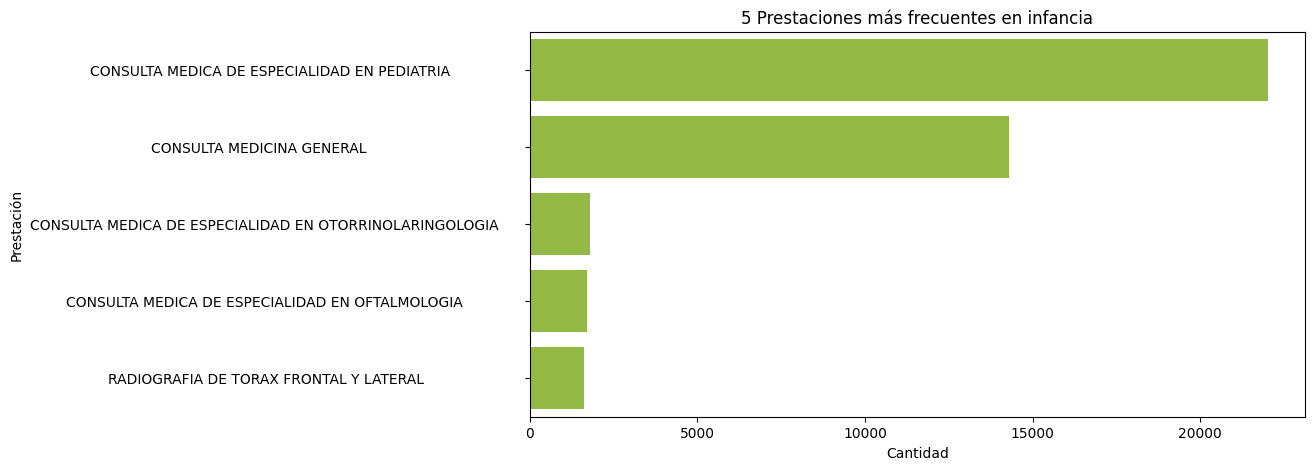

In [78]:
# Graficamos las 5 prestaciones más frecuentes del grupo1 niñez
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo1, y='NOMBRE_PRESTACIÓN', order=grupo1['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='yellowgreen')
plt.title('5 Prestaciones más frecuentes en infancia')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

En el grupo1 de niñez, las prestaciones más frecuentes son las relacionadas con vacunación y controles pediátricos.

##### Grupo 2: 

In [79]:
# Filtramos las 5 prestaciones más frecuentes en el grupo2 adolescencia
grupo2['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       11264
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     3380
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  2550
PSICOTERAPIA INDIVIDUAL                                          2419
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      2082
Name: count, dtype: int64

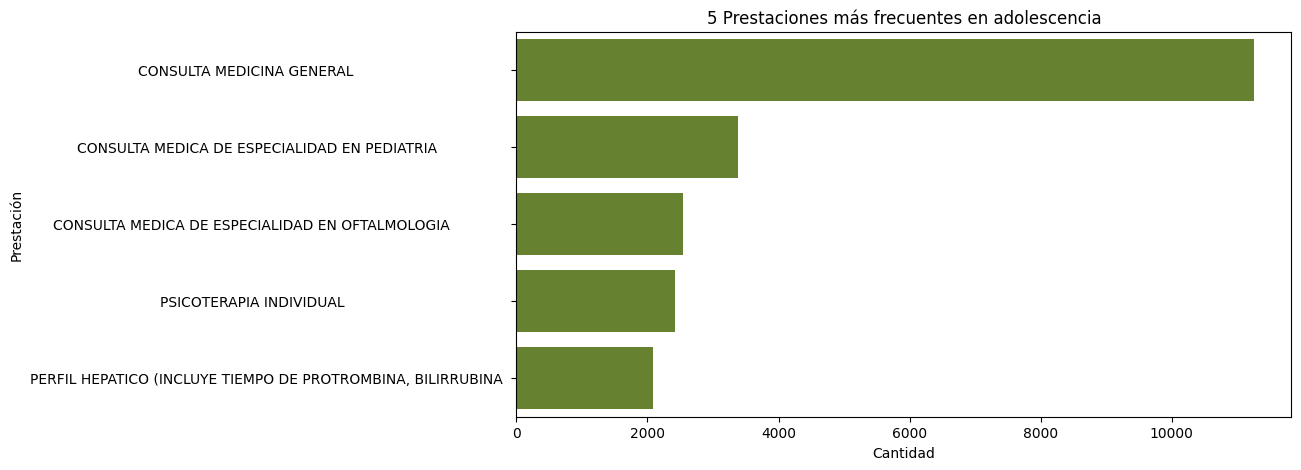

In [80]:
# Graficamos las 5 prestaciones más frecuentes del grupo2 adolescencia
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo2, y='NOMBRE_PRESTACIÓN', order=grupo2['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='olivedrab')
plt.title('5 Prestaciones más frecuentes en adolescencia')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

En el grupo2 de adolescencia, las prestaciones más frecuentes son las relacionadas con controles médicos y vacunación.


##### Grupo 3:

In [81]:
grupo3.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO    NOMBRE_PRESTACIÓN                                           
20 a 24 años  CONSULTA MEDICINA GENERAL                                       10020
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     3049
              VENOSA EN ADULTOS                                                1921
25 a 29 años  CONSULTA MEDICINA GENERAL                                       12610
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     4628
              VENOSA EN ADULTOS                                                2455
30 a 34 años  CONSULTA MEDICINA GENERAL                                       13618
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     5027
              VENOSA EN ADULTOS                                                2753
35 a 39 años  CONSULTA MEDICINA GENERAL                                       12048
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     3808
 

In [82]:
# Filtramos las 5 prestaciones más frecuentes en el grupo3 adultez
grupo3['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       87850
CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA    24140
VENOSA EN ADULTOS                                               19898
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     15697
HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,        14562
Name: count, dtype: int64

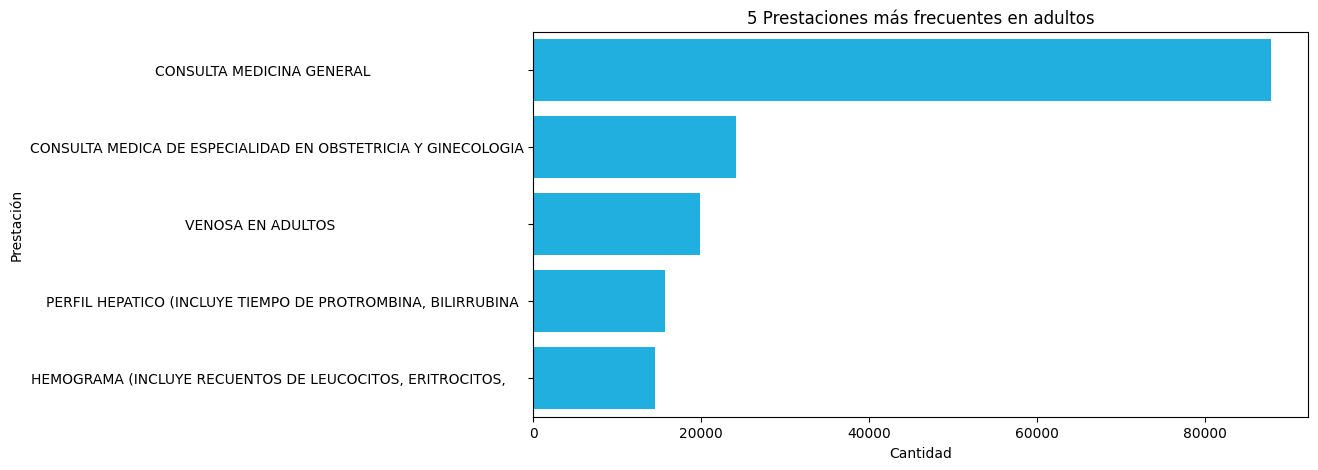

In [83]:
# Graficamos las 5 prestaciones más frecuentes del grupo3 adultez
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo3, y='NOMBRE_PRESTACIÓN', order=grupo3['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='deepskyblue')
plt.title('5 Prestaciones más frecuentes en adultos')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

En el grupo3 de adultos, las prestaciones más frecuentes son las relacionadas con controles médicos y vacunación.

##### Grupo 4:

In [84]:
grupo4.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
60 a 64 años    CONSULTA MEDICINA GENERAL                                       8418
                VENOSA EN ADULTOS                                               3085
                CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA    2229
65 a 69 años    CONSULTA MEDICINA GENERAL                                       7252
                VENOSA EN ADULTOS                                               3075
                CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 2371
70 a 74 años    CONSULTA MEDICINA GENERAL                                       5582
                VENOSA EN ADULTOS                                               2593
                CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 2080
75 a 79 años    CONSULTA MEDICINA GENERAL                                       4191
                VENOSA EN ADULTOS                                        

In [85]:
# Filtramos las 5 prestaciones más frecuentes en el grupo4 vejez
grupo4['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       30420
VENOSA EN ADULTOS                                               13013
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 10263
HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,         8828
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      8609
Name: count, dtype: int64

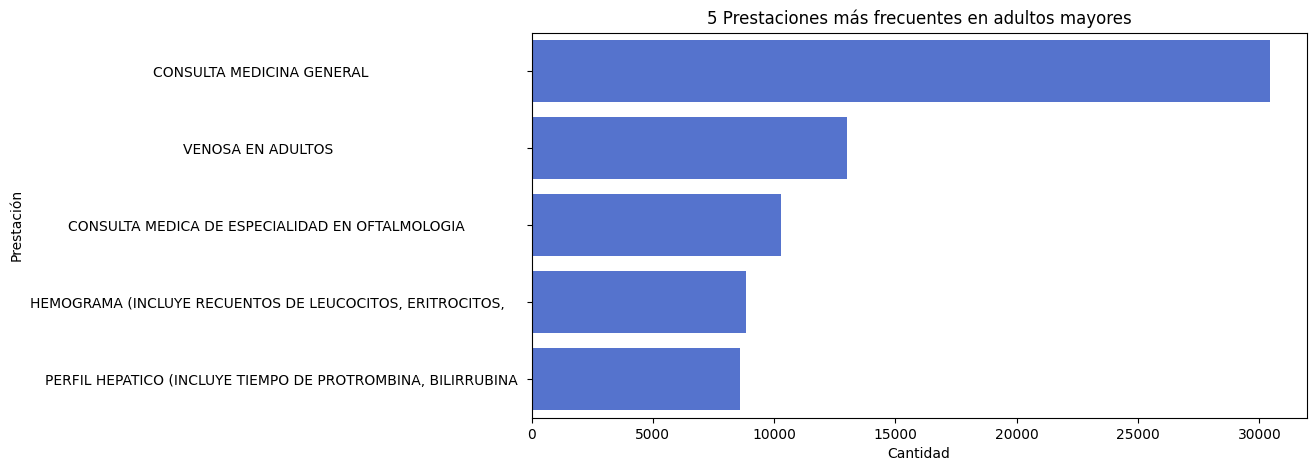

In [86]:
# Graficamos las 5 prestaciones más frecuentes del grupo etario de adultos mayores
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo4, y='NOMBRE_PRESTACIÓN', order=grupo4['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='royalblue')
plt.title('5 Prestaciones más frecuentes en adultos mayores')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

En el grupo4 de adultos mayores, las prestaciones más frecuentes son las relacionadas con controles médicos y vacunación.

##### PRESTACIONES MÁS FRECUENTES POR GÉNERO:

In [87]:
# Tipos de prestación médica más frecuentes por género
mle_2023_df.groupby('SEXO')['NOMBRE_PRESTACIÓN'].value_counts()

SEXO    NOMBRE_PRESTACIÓN                                           
Hombre  CONSULTA MEDICINA GENERAL                                       51981
        CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    12949
        VENOSA EN ADULTOS                                               11697
        CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 10386
        PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      9514
                                                                        ...  
Mujer   URETEROPIELOGRAFIA ASCENDENTE (DIRECTA) POR CATETERISMO             1
        VARICOCELE                                                          1
        VIDEOFLUOROSCOPIA PARA ESTUDIO DE DEGLUCION                         1
        VIH, CARGA VIRAL                                                    1
        VITAMINA B6 POR HPLC                                                1
Name: count, Length: 2205, dtype: int64

In [88]:
# 10 prestaciones más frecuentes por género femenino
mle_2023_df[mle_2023_df['SEXO'] == 'Mujer']['NOMBRE_PRESTACIÓN'].value_counts().head(10)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       91852
CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA    27934
VENOSA EN ADULTOS                                               22613
HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,        17517
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     17446
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 16909
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12             15760
TIROESTIMULANTE (TSH), HORMONA (ADULTO, NIÑO O R.N.)            14487
25 OH VITAMINA D TOTAL POR INMUNOENSAYO                         13418
PERFIL LIPIDICO (INCLUYE MEDICIONES DE COLESTEROL TOTAL,        13385
Name: count, dtype: int64

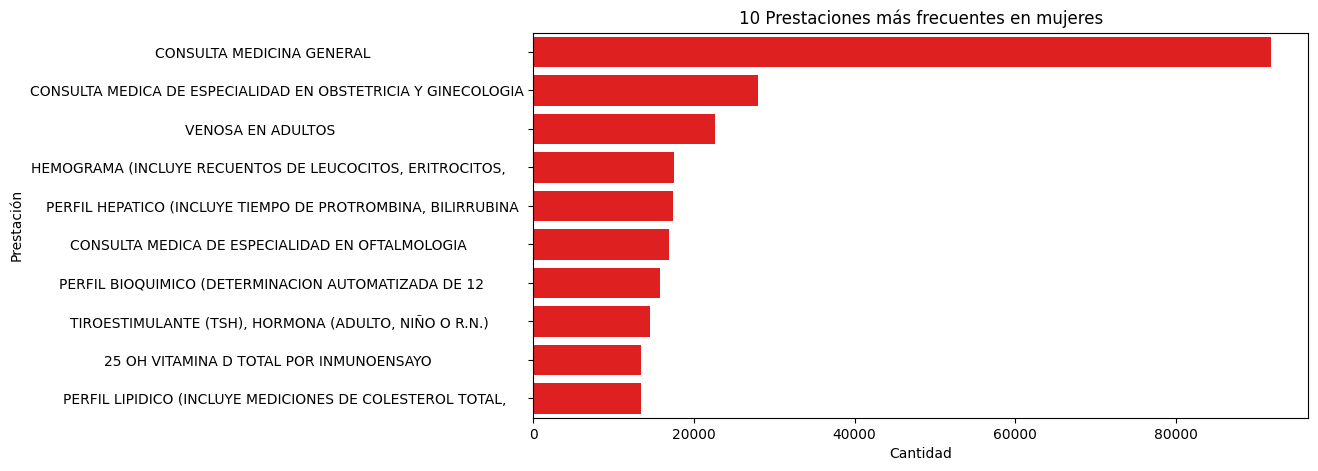

In [89]:
# Graficamos en un gráfico de barras lateral para las 10 prestaciones más frecuentes del género femenino
plt.figure(figsize=(10, 5))
sns.countplot(data=mle_2023_df[mle_2023_df['SEXO'] == 'Mujer'], y='NOMBRE_PRESTACIÓN', order=mle_2023_df[mle_2023_df['SEXO'] == 'Mujer']['NOMBRE_PRESTACIÓN'].value_counts().index[:10], color='red')
plt.title('10 Prestaciones más frecuentes en mujeres')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

In [90]:
# 10 prestaciones más frecuentes por género masculino
mle_2023_df[mle_2023_df['SEXO'] == 'Hombre']['NOMBRE_PRESTACIÓN'].value_counts().head(10)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       51981
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    12949
VENOSA EN ADULTOS                                               11697
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                 10386
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      9514
CONSULTA MEDICA DE ESPECIALIDAD EN UROLOGIA                      9275
HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,         8872
CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA     8431
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              8222
ANTIGENO PROSTATICO ESPECIFICO                                   7761
Name: count, dtype: int64

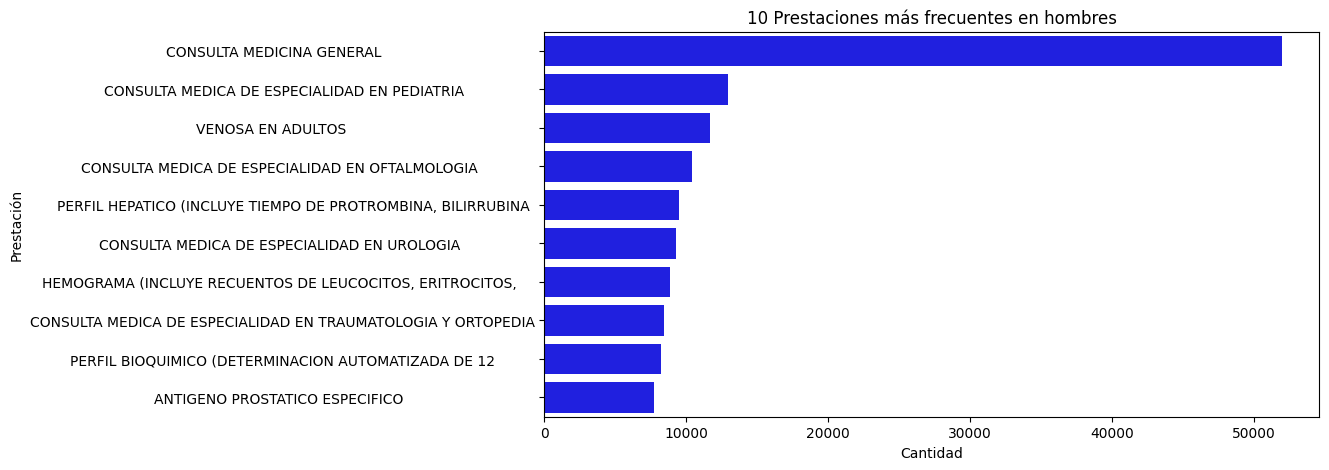

In [91]:
# Graficamos en un gráfico de barras lateral para las 10 prestaciones más frecuentes del género masculino
plt.figure(figsize=(10, 5))
sns.countplot(data=mle_2023_df[mle_2023_df['SEXO'] == 'Hombre'], y='NOMBRE_PRESTACIÓN', order=mle_2023_df[mle_2023_df['SEXO'] == 'Hombre']['NOMBRE_PRESTACIÓN'].value_counts().index[:10], color='blue')
plt.title('10 Prestaciones más frecuentes en hombres')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

#### Análisis general:

##### Edad
El análisis de las prestaciones médicas según el rango etario refleja patrones esperados basados en las necesidades de salud asociadas a cada etapa de la vida:

- En las edades más bajas, predominan las atenciones relacionadas con pediatría y consulta general, lo cual es coherente con el seguimiento del desarrollo infantil, la vacunación y la atención de enfermedades comunes en la infancia.
- La prestación de psicoterapia aparece exclusivamente en el grupo de adolescentes, lo que subraya la relevancia de abordar problemas emocionales y de salud mental en esta etapa crítica de desarrollo.
- Las prestaciones como consulta general, perfil hepático y perfil bioquímico se mantienen frecuentes en todos los grupos etarios. Esto puede explicarse por su uso en chequeos rutinarios o como parte de estrategias preventivas para monitorear la salud general de la población.

##### Género 
El análisis de la distribución de prestaciones médicas entre géneros evidencia diferencias notables:

- Las mujeres acceden a más atenciones médicas que los hombres, con una diferencia significativa en la prestación más demandada (10,000 atenciones para mujeres frente a 6,000 para hombres en el top 1).
- Las prestaciones de obstetricia y ginecología son claramente predominantes en las mujeres, lo que refleja necesidades relacionadas con la salud reproductiva y materna.
- El perfil hepático, asociado a chequeos generales o diagnósticos específicos, resulta una prestación común entre ambos géneros, lo que indica su relevancia en el monitoreo de la salud hepática independientemente del género.
- En el caso de pediatría, se observa una mayor cantidad de consultas para hombres que para mujeres. Este patrón podría estar vinculado a diferencias biológicas, sociales o culturales en el acceso o la demanda de estos servicios para niños y niñas.

## 2. ¿Cómo varía la cantidad y tipo de prestaciones emitidas según el mes del año? ¿Existen patrones estacionales?

¿Cómo varía la cantidad y tipo de prestaciones emitidas según el mes del año? ¿Existen patrones estacionales?

df mle_2023 para mes de Enero y Series para N_POR_PRESTACION para mes de enero

In [ ]:
mle_2023_df_01 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202301]
print(len(mle_2023_df_01)) # cantidad de prestaciones enero
n_por_prestacion_01 = mle_2023_df_01.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_1 = n_por_prestacion_01


5875


df mle_2023 para mes de Febrero y Series para N_POR_PRESTACION para mes de febrero

In [ ]:
mle_2023_df_02 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202302]
print(len(mle_2023_df_02)) # cantidad de prestaciones febrero
n_por_prestacion_02 = mle_2023_df_02.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_2 = n_por_prestacion_02

6232


df mle_2023 para mes de marzo y Series para N_POR_PRESTACION para mes de marzo

In [ ]:
mle_2023_df_03 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202303]
print(len(mle_2023_df_03)) # cantidad de prestaciones marzo
n_por_prestacion_03 = mle_2023_df_03.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_3 = n_por_prestacion_03

10646


df mle_2023 para mes de abril y Series para N_POR_PRESTACION para mes de abril

In [ ]:
mle_2023_df_04 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202304]
print(len(mle_2023_df_04)) # cantidad de prestaciones abril
n_por_prestacion_04 = mle_2023_df_04.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_4 = n_por_prestacion_04

10278


df mle_2023 para mes de mayo y Series para N_POR_PRESTACION para mes de mayo

In [ ]:
mle_2023_df_05 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202305]
print(len(mle_2023_df_05)) # cantidad de prestaciones mayo
n_por_prestacion_05 = mle_2023_df_05.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_5 = n_por_prestacion_05

17594


df mle_2023 para mes de junio y Series para N_POR_PRESTACION para mes de junio

In [ ]:
mle_2023_df_06 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202306]
print(len(mle_2023_df_06)) # cantidad de prestaciones junio
n_por_prestacion_06 = mle_2023_df_06.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_6 = n_por_prestacion_06

9036


df mle_2023 para mes de julio y Series para N_POR_PRESTACION para mes de julio

In [ ]:
mle_2023_df_07 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202307]
print(len(mle_2023_df_07)) # cantidad de prestaciones julio
n_por_prestacion_07 = mle_2023_df_07.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_7 = n_por_prestacion_07

6067


df mle_2023 para mes de agosto y Series para N_POR_PRESTACION para mes de agosto

In [ ]:
mle_2023_df_08 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202308]
print(len(mle_2023_df_08)) # cantidad de prestaciones enero
n_por_prestacion_08 = mle_2023_df_08.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_8 = n_por_prestacion_08

10093


df mle_2023 para mes de septiembre y Series para N_POR_PRESTACION para mes de septiembre

In [ ]:
mle_2023_df_09 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202309]
print(len(mle_2023_df_09)) # cantidad de prestaciones septiembre
n_por_prestacion_09 = mle_2023_df_09.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_9 = n_por_prestacion_09

5489


df mle_2023 para mes de octubre y Series para N_POR_PRESTACION para mes de octubre

In [ ]:
mle_2023_df_10 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202310]
print(len(mle_2023_df_10)) # cantidad de prestaciones octubre
n_por_prestacion_10 = mle_2023_df_10.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_10 = n_por_prestacion_10

6016


df mle_2023 para mes de noviembre y Series para N_POR_PRESTACION para mes de noviembre

In [ ]:
mle_2023_df_11 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202311]
print(len(mle_2023_df_11)) # cantidad de prestaciones noviembre
n_por_prestacion_11 = mle_2023_df_11.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_11 = n_por_prestacion_11

7869


df mle_2023 para mes de diciembre y Series para N_POR_PRESTACION para mes de diciembre

In [ ]:
mle_2023_df_12 = mle_2023_df[mle_2023_df['MES_EMISION'] == 202312]
print(len(mle_2023_df_12)) # cantidad de prestaciones diciembre
n_por_prestacion_12 = mle_2023_df_12.groupby('CODIGO_PRESTACIÓN')['CODIGO_PRESTACIÓN'].count()
fila_12 = n_por_prestacion_12

4628


Agrupamos en una misma estructura de datos para acceder a los datos

In [ ]:
verano = [fila_1,
          fila_2,
          fila_3]

otono = [fila_4,
         fila_5,
         fila_6]

invierno = [fila_7,
            fila_8,
            fila_9]

primavera = [fila_10,
             fila_11,
             fila_12]

por_estaciones = [verano,
                  otono,
                  invierno,
                  primavera]

por_meses = [fila_1,
             fila_2,
             fila_3,
             fila_4,
             fila_5,
             fila_6,
             fila_7,
             fila_8,
             fila_9,
             fila_10,
             fila_11,
             fila_12]

Generador interactivo de gráficos meses o estaciones del año vs cantidad de prestaciones para una determinada prestación

In [ ]:
meses = True                 # varible que define si vamos a generar el gráfico en base a meses o a estaciones
codigo_prestacion = 101001   # varible para indicar la prestacion a analizar

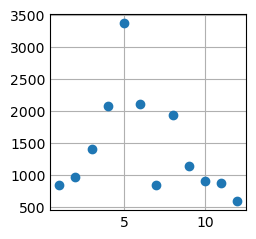

In [ ]:
fig, ax = plt.subplots()
if meses == True:
    ax.scatter([1,2,3,4,5,6,7,8,9,10,11,12], [por_meses[0][codigo_prestacion],
                                              por_meses[1][codigo_prestacion],
                por_meses[2][codigo_prestacion],
                por_meses[3][codigo_prestacion],
                por_meses[4][codigo_prestacion],
                por_meses[5][codigo_prestacion],
                por_meses[6][codigo_prestacion],
                por_meses[7][codigo_prestacion],
                por_meses[8][codigo_prestacion],
                por_meses[9][codigo_prestacion],
                por_meses[10][codigo_prestacion],
                por_meses[11][codigo_prestacion]])

else:

    ax.scatter([1, 2, 3, 4], [por_estaciones[0][codigo_prestacion] + por_estaciones[0][codigo_prestacion] + por_estaciones[0][codigo_prestacion],
                  por_estaciones[1][codigo_prestacion] + por_estaciones[1][codigo_prestacion] + por_estaciones[1][codigo_prestacion],
                  por_estaciones[2][codigo_prestacion] + por_estaciones[2][codigo_prestacion] + por_estaciones[2][codigo_prestacion],
                  por_estaciones[3][codigo_prestacion] + por_estaciones[3][codigo_prestacion] + por_estaciones[3][codigo_prestacion]])


plt.show()

---

## 3. ¿Qué tipos de prestación médica son más frecuentes en cada región?

**Aclaraciones**  

- Usaremos el archivo **Regional.shp** para graficar el mapa de Chile, con las regiones delimitadas.
  
- Utilizaremos la librería **fuzzywuzzy** (específicamente `from fuzzywuzzy import process`) para hacer coincidir los nombres de regiones en el DataFrame **mle_2023_df** con los nombres presentes en el shapefile **mapa**.


### Introduccion

La salud es un aspecto fundamental para cualquier sociedad, y entender cómo se distribuyen las prestaciones médicas en un país como Chile puede revelar patrones clave. Por ello, en este análisis buscamos identificar los tipos de prestaciones médicas más frecuentes en cada región. Para lograrlo, utilizamos un conjunto de datos que incluye información sobre prestaciones, regiones de emisión y su frecuencia de uso.

**Elección de variables**  

Para analizar los tipos de prestaciones médicas más frecuentes en cada región, hemos seleccionado las siguientes variables:

1. REGION_EMISION: Esta variable es fundamental, ya que nos permite identificar la región de emisión de cada prestación médica, lo cual es clave para realizar el análisis por región.

2. NOMBRE_PRESTACIÓN: Esta variable describe el tipo de prestación médica (por ejemplo, consultas, procedimientos quirúrgicos, etc.). Nos proporciona la categoría de la prestación, lo que nos permite segmentar el análisis según el tipo de servicio médico.

3. FRECUENCIA: Usamos esta variable para conocer cuántas veces se ha realizado cada tipo de prestación médica en cada región. Esto nos permitirá identificar las prestaciones más comunes en cada región.

In [92]:
# Agrupar por región y tipo de prestación
prestaciones_por_region = mle_2023_df.groupby(['REGION_EMISION', 'NOMBRE_PRESTACIÓN']).size().reset_index(name='FRECUENCIA')

In [93]:
# Ordenar por región y frecuencia descendente
prestaciones_por_region = prestaciones_por_region.sort_values(['REGION_EMISION', 'FRECUENCIA'], ascending=[True, False])

In [94]:
prestaciones_mas_frecuentes = prestaciones_por_region.groupby('REGION_EMISION').first().reset_index()

In [95]:
prestaciones_mas_frecuentes

,REGION_EMISION,NOMBRE_PRESTACIÓN,FRECUENCIA
0,De Antofagasta,CONSULTA MEDICINA GENERAL ...,4933
1,De Arica Y Parinacota,CONSULTA MEDICINA GENERAL ...,873
2,De Atacama,CONSULTA MEDICINA GENERAL ...,1974
3,De Aysén Del Gral. C. Ibáñez Del Campo,CONSULTA MEDICINA GENERAL ...,161
4,De Coquimbo,CONSULTA MEDICINA GENERAL ...,7243
5,De La Araucanía,CONSULTA MEDICINA GENERAL ...,4138
6,De Los Lagos,CONSULTA MEDICINA GENERAL ...,6953
7,De Los Ríos,CONSULTA MEDICINA GENERAL ...,3085
8,De Magallanes Y De La Antártica Chilena,CONSULTA MEDICINA GENERAL ...,918
9,De Tarapacá,CONSULTA MEDICINA GENERAL ...,2132


**Distribución de los datos**  

En primera instancia, veremos la distribución de los datos por región, específicamente los tipos de prestación médica más frecuentes en cada una.


C:\Users\benja\AppData\Local\Temp\ipykernel_10260\1012203669.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))


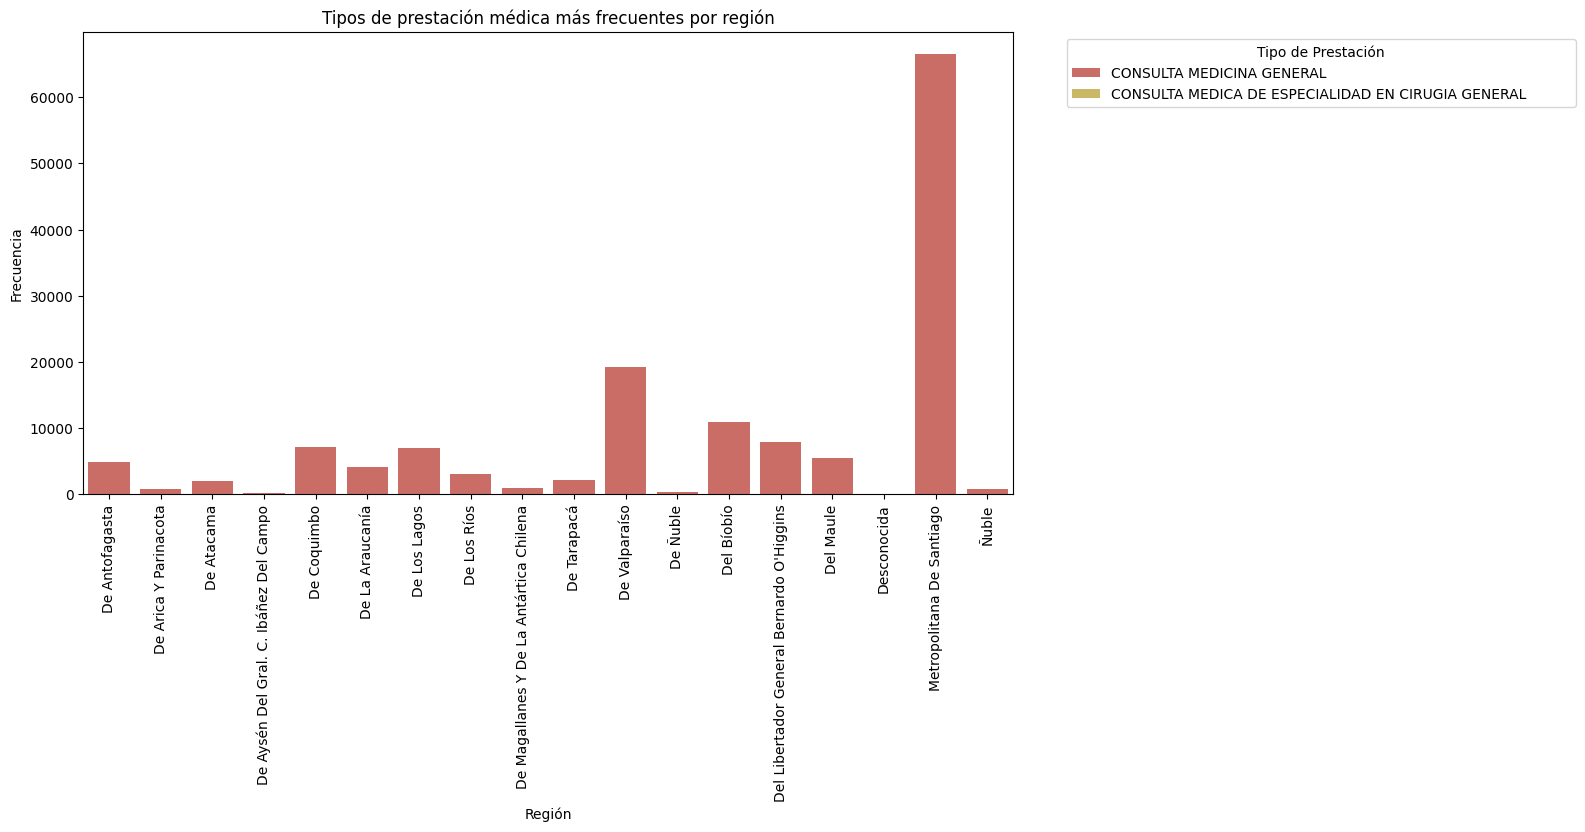

In [96]:
plt.figure(figsize=(12, 6))
sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))
plt.title('Tipos de prestación médica más frecuentes por región')
plt.xlabel('Región')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de Prestación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

 A continuación, se presenta un gráfico de barras donde se muestra la frecuencia de cada tipo de prestación médica en función de la región. El eje X representa las regiones de emisión, mientras que el eje Y indica la frecuencia de cada tipo de prestación. Los colores en las barras corresponden a los distintos tipos de prestaciones médicas, facilitando la visualización de cuál es más común en cada región.

**Análisis del Gráfico**

En este análisis, la prestación médica más frecuente en todas las regiones es la "CONSULTA MÉDICA GENERAL". Sin embargo, aunque esta prestación se repite en todas las regiones, las frecuencias varían, con algunas regiones presentando una mayor cantidad de consultas que otras.

**Distribución geográfica de los datos**

En segunda instancia, mostraremos geográficamente la frecuencia de las prestaciones médicas por región. Utilizaremos el shapefile con la información geográfica de Chile y el dataframe con los datos de las prestaciones más frecuentes, emparejando las regiones utilizando la librería fuzzywuzzy para asegurar que los nombres coincidan correctamente. 

In [97]:
# se usa este archivo para poder graficar el mapa de Chile por regiones
mapa = gpd.read_file("../data/Regiones/Regional.shp")
mapa

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
0,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-7727277.278 -1997230.768, -7726464...."
1,1085,2,1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-7810213.515 -2298008.28, -781..."
2,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78..."
3,1087,15,12,133053.142345,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-7494057.535 -7542535.383, -74..."
4,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-8413517.696 -6234055.255, -84..."
5,1089,4,3,75661.248635,9.643906e+10,2.401741e+06,Región de Atacama,"MULTIPOLYGON (((-7932747.768 -3311218.615, -79..."
6,1090,5,4,40575.901682,5.498082e+10,2.065933e+06,Región de Coquimbo,"MULTIPOLYGON (((-7963268.9 -3784870.143, -7963..."
7,1091,6,5,16322.970393,2.301475e+10,1.679609e+06,Región de Valparaíso,"MULTIPOLYGON (((-8991645.917 -3991821.789, -89..."
8,1092,7,13,15392.030737,2.225204e+10,1.064253e+06,Región Metropolitana de Santiago,"POLYGON ((-7873736.745 -3885505.642, -7873695...."
9,1093,13,10,48408.371357,8.771834e+10,7.874158e+06,Región de Los Lagos,"MULTIPOLYGON (((-8331768.181 -5403721.402, -83..."


Para emparejar nombres similares, utilizamos la librería [fuzzywuzzy](https://stackoverflow.com/questions/41171665/python-fuzzywuzzys-process-extract-how-does-it-work), específicamente la función `process.extractOne()`, que nos permite buscar la coincidencia más cercana entre cadenas de texto. En este caso, la utilizaremos para emparejar los nombres de las regiones entre el dataframe `beneficiarios_df` y el shapefile `mapa`.


<Figure size 1200x800 with 0 Axes>

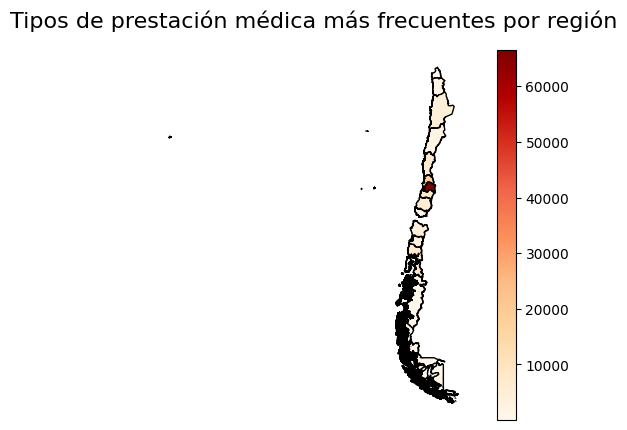

In [98]:
# Emparejar nombres similares
nombres_mapa = mapa['Region'].unique()
nombres_prestaciones = prestaciones_mas_frecuentes['REGION_EMISION'].unique()

# Crear un diccionario de coincidencias
matches = {nombre: process.extractOne(nombre, nombres_mapa)[0] for nombre in nombres_prestaciones}

# Reemplazar nombres en prestaciones_mas_frecuentes
prestaciones_mas_frecuentes['Region'] = prestaciones_mas_frecuentes['REGION_EMISION'].map(matches)

# Unir con el shapefile
mapa_regiones = mapa.merge(prestaciones_mas_frecuentes, on='Region', how='left')

plt.figure(figsize=(12, 8))
mapa_regiones.plot(column='FRECUENCIA', cmap='OrRd', legend=True, edgecolor='black')
plt.title('Tipos de prestación médica más frecuentes por región', fontsize=16)
plt.axis('off')
plt.show()

A continuación, se presenta un mapa geográfico donde se visualiza la frecuencia de las prestaciones médicas más comunes por región. En este mapa, las regiones están representadas mediante colores que indican la frecuencia de la prestación médica más frecuente en cada una. Las regiones con colores más intensos muestran una mayor frecuencia, lo que facilita la comparación visual de las diferencias en la distribución de las prestaciones médicas a lo largo del país.

**Análisis del Gráfico**

En este análisis, por ejemplo, la Región Metropolitana de Santiago presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, tienen frecuencias considerablemente más bajas. Esta diferencia en las frecuencias refleja la diversidad en la distribución y demanda de servicios médicos a lo largo del país.

### ¿Qué podría salir mal?

- Limitaciones de los datos:
  
  1. Dado que los nombres de las regiones no coinciden exactamente entre el dataframe utilizado y el shapefile, podría haber problemas al graficar si no se cuenta con el conocimiento o las herramientas adecuadas para realizar el emparejamiento correctamente.
  2. Las frecuencias de las prestaciones podrían no reflejar la realidad debido a posibles errores de registro o limitaciones en la cobertura de los datos.

- Sesgos inherentes:
  1. El análisis no considera factores como la calidad del servicio, el acceso físico a centros médicos, o las diferencias en infraestructura entre regiones.

### Conclusion

En este análisis, se exploró la frecuencia de las prestaciones médicas más comunes en diversas regiones del país, utilizando tanto un gráfico de barras como un mapa geográfico para visualizar los resultados. Se identificó que la prestación médica más frecuente en todas las regiones es la "Consulta Médica General", aunque las frecuencias varían significativamente entre las regiones. La Región Metropolitana de Santiago, por ejemplo, presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, muestran una demanda mucho menor.

Este patrón de distribución refleja no solo las diferencias en el acceso y la demanda de servicios médicos, sino también posibles disparidades regionales en infraestructura y atención sanitaria. Las regiones más urbanizadas tienden a tener una mayor concentración de consultas, mientras que las zonas más alejadas podrían enfrentar desafíos relacionados con la disponibilidad y el acceso a estos servicios.

En resumen, este análisis destaca la importancia de considerar las diferencias regionales en el acceso a la atención médica y la necesidad de políticas públicas que aborden estas desigualdades para mejorar la cobertura y la calidad de los servicios de salud en todo el país.

## 4. ¿Cómo se relacionan los distintos tramos de Fonasa con la frecuencia y el tipo de prestaciones recibidas?

### ¿Cómo se relacionan los distintos tramos de Fonasa con la frecuencia y el tipo de prestaciones recibidas?


### Queremos estudiar los distintos tramos para poder adquirir contexto de los distintos tramos y sus comportamientos respectos a los distintos tipo de producto de Fonasa que la poblacion estuvo haciendo.

### Primero vamos a analizar el contexto de los datos en los que nos encontramos respecto a cierta porcion de la totalidad de la base de datos y luego vamos a poder realizar un estudio normalizado de todos los datos.

In [99]:
# Calcular la frecuencia total de prestaciones por tramo Fonasa
cant_por_tramo = mle_2023_df.groupby("TRAMO_FONASA")["PRESTACIONES"].sum().reset_index()

cant_por_tramo.columns = ["Tramo Fonasa", "Total Prestaciones"]

print(cant_por_tramo)


  Tramo Fonasa  Total Prestaciones
0            A               311.0
1            B            559334.0
2            C            210459.0
3            D            448661.0
4            X              5865.0


In [100]:
# Agrupar por tramo y tipo de prestación (sección)
tipo_por_tramo = mle_2023_df.groupby(["TRAMO_FONASA", "DESC_SECCION"])["PRESTACIONES"].sum().reset_index()

# Sorteamos
tipo_por_tramo = tipo_por_tramo.sort_values(["TRAMO_FONASA", "PRESTACIONES"], ascending=[True, False])

tipo_por_tramo.head()


,TRAMO_FONASA,DESC_SECCION,PRESTACIONES
1,A,Exámenes De Diagnóstico,160.0
0,A,Atención Médica,107.0
3,A,Otros Profesionales,21.0
7,A,Proc. Apoyo Clínico Y Terap.,13.0
5,A,Pae,4.0


### De aqui podremos ver ordenada segun la edad y el tramo para adquirir tambien cierta nocion de la forma en que esos datos estan distribuidos en la poblacion segun distintas variables

In [101]:
# Agrupar por tramo Fonasa y edad
distribucion_edad = beneficiarios_df.groupby(["TRAMO_FONASA", "EDAD_TRAMO"]).size().reset_index(name="Count")

distribucion_edad.head()


,TRAMO_FONASA,EDAD_TRAMO,Count
0,A,0 a 9 años,38498
1,A,10 a 19 años,51114
2,A,20 a 29 años,19580
3,A,30 a 39 años,20522
4,A,40 a 49 años,18286


### Equivalentemente lo mismo para los generos

In [102]:
# Agrupar por tramo Fonasa y sexo
distribucion_genero = beneficiarios_df.groupby(["TRAMO_FONASA", "SEXO"]).size().reset_index(name="Count")

print(distribucion_genero)


   TRAMO_FONASA             SEXO   Count
0             A           Hombre   77784
1             A            Mujer  104603
2             A  Sin información      28
3             B           Hombre  176300
4             B            Mujer  232585
5             B  Sin información      16
6             C           Hombre   85697
7             C            Mujer   79036
8             C  Sin información      13
9             D           Hombre  137971
10            D            Mujer  105960
11            D  Sin información       7


### Ahora vamos a graficar segun el sample que sacamos de la base de datos de MLE para poder adquirir cierta nocion del por un lado el tramo y luego la frecuencia de esta respecto al sample que obtuvimos.

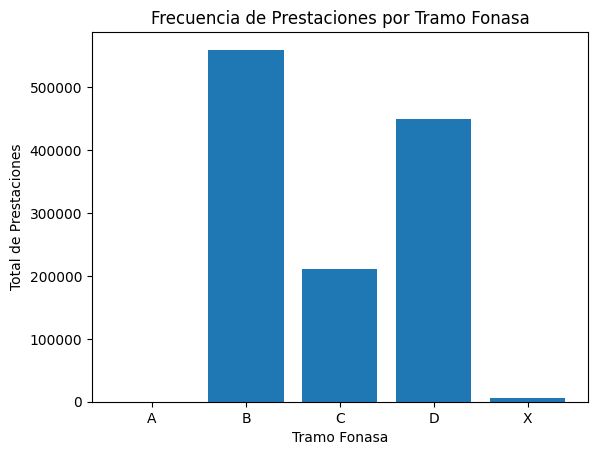

In [103]:
import matplotlib.pyplot as plt

plt.bar(cant_por_tramo["Tramo Fonasa"], cant_por_tramo["Total Prestaciones"])
plt.title("Frecuencia de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Total de Prestaciones")
plt.show()


### Luego aca podemos analizar la distribucion de tipos de prestacion por tramo y poder analizar la porcion que cada distribucion adquiere en nuestro sample.

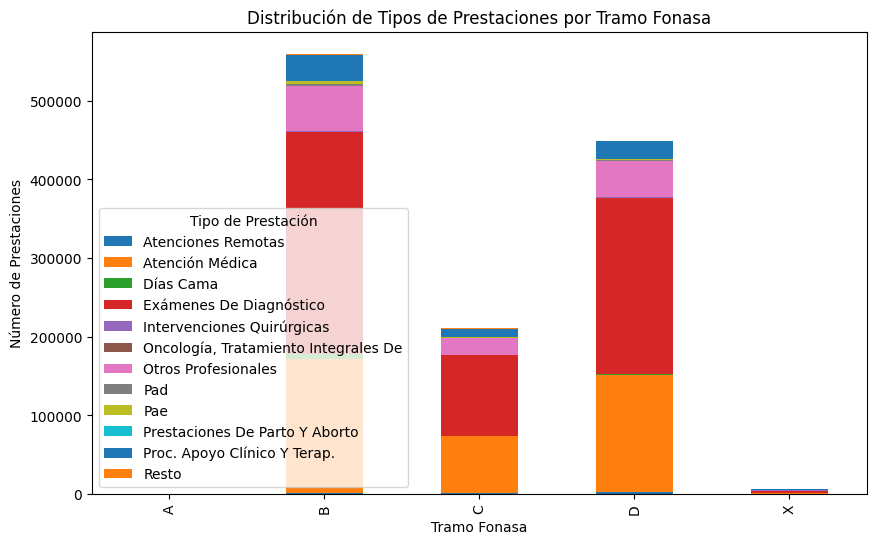

In [104]:
# Gráfico apilado para tipos de prestaciones por tramo
type_pivot = tipo_por_tramo.pivot(index="TRAMO_FONASA", columns="DESC_SECCION", values="PRESTACIONES")
type_pivot.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Distribución de Tipos de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Número de Prestaciones")
plt.legend(title="Tipo de Prestación")
plt.show()


### Finalmente aplicamos cierta normalizacion segun la norma para poder adquirir una nocion que trasciende las distribuciones relativas segun el tipo de sample que uno quiera adquirir

Ahora analizando las relaciones y porcentajes entre las variables tenemos:

In [105]:
# Calcular la frecuencia total de prestaciones por tramo Fonasa
cant_por_tramo = mle_2023_df.groupby("TRAMO_FONASA")["PRESTACIONES"].sum().reset_index()
cant_por_tramo.columns = ["Tramo Fonasa", "Total Prestaciones"]

tipo_por_tramo = mle_2023_df.groupby(["TRAMO_FONASA", "DESC_SECCION"])["PRESTACIONES"].sum().reset_index()

tipo_por_tramo = tipo_por_tramo.sort_values(["TRAMO_FONASA", "PRESTACIONES"], ascending=[True, False])


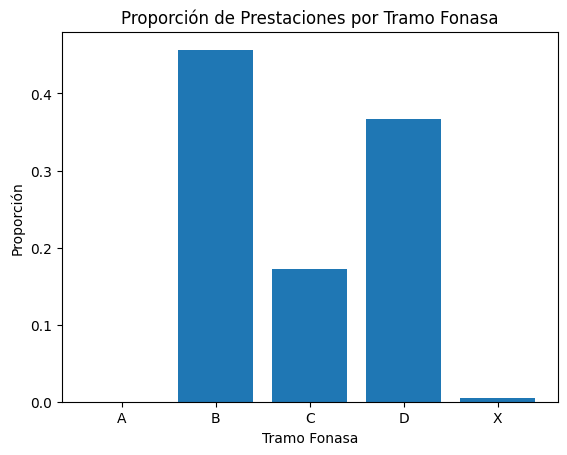

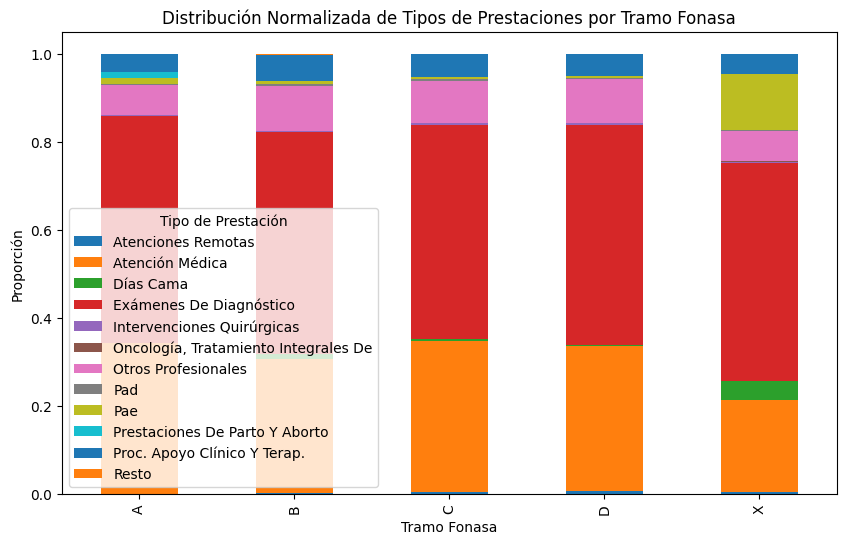

In [106]:
# Normalizar frecuencia total de prestaciones por tramo
cant_por_tramo["Proporción"] = cant_por_tramo["Total Prestaciones"] / cant_por_tramo["Total Prestaciones"].sum()

# Normalizar tipos de prestaciones por tramo
tipo_por_tramo["Proporción"] = tipo_por_tramo.groupby("TRAMO_FONASA")["PRESTACIONES"].transform(lambda x: x / x.sum())

plt.bar(cant_por_tramo["Tramo Fonasa"], cant_por_tramo["Proporción"])
plt.title("Proporción de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Proporción")
plt.show()

type_pivot_normalized = tipo_por_tramo.pivot(index="TRAMO_FONASA", columns="DESC_SECCION", values="Proporción")
type_pivot_normalized.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Distribución Normalizada de Tipos de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Proporción")
plt.legend(title="Tipo de Prestación")
plt.show()  


### Podemos luego terminar analizando y concluyendo los tramos y las distintas distribuciones que son mas consumidas por los clientes de Fonasa, por un lado los Examenes de Diagnostico en la totalidad de los distintos tramos y de la misma forma las atenciones medicas las cuales hacen sentido ya que se podria decir que es lo que la gente mas hace sin necesidad de buscar cierta atencion especial

## 5 - ¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?

### Introduccion

Es sabido que a medida que uno envejece suele ir con mayor frecuencia al medico y por implicancia sus gastos medicos deben aumentar, pero la pregunta es... Que tanto aumentan estos gastos, existe un punto de quiebre o es gradual?.  
~~Más aun, se puede predecir el gasto promedio medico en Chile segun la edad de personas adscritas a FONASA?. Si pensamos en agrupar segun region, genero, tramo de fonasa, etc... existen diferencias clave?~~

**Elección de variables**  
Como buscamos medir los gastos medicos promedio a medida que una persona envejece, pero tomando en cuenta que no tenemos el historial medico completo de una persona (Lo ideal) usaremos:
1. La "EDAD_TRAMO", puesto que analizaremos un promedio en gastos, para todo el tramo edad del año 2023.
2. El "MONTO_COPAGO" para conocer el monto a pagar por cada prestacion.  
3. Opcional: El "SEXO" para especificar el analisis, pero podria ser cualquiera; "TRAMO_FONASA", "REGION_EMISION", "MES_EMISION", etc...

In [107]:
# Ordenar los datos por "EDAD_TRAMO"
mle_2023_df["EDAD_TRAMO_ORDEN"] = (mle_2023_df["EDAD_TRAMO"].str.extract(r"(\d+)").astype("Int64"))
mle_2023_df = mle_2023_df.sort_values("EDAD_TRAMO_ORDEN")

**Distribución de los datos**  
En primera instancia, veremos la distribución de los datos por tramo de edad.

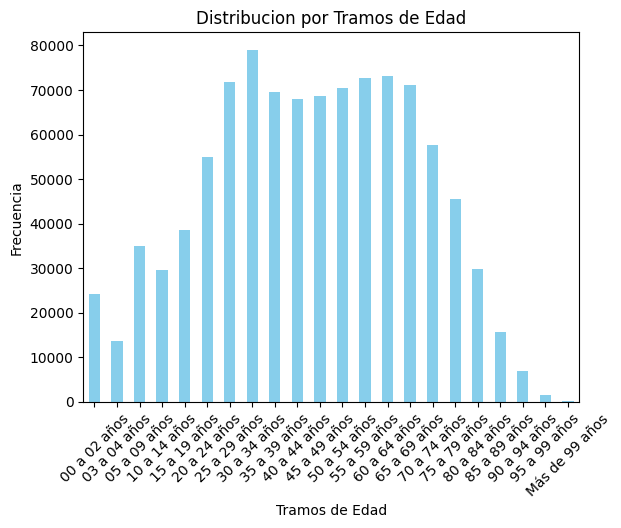

In [108]:
mle_2023_df["EDAD_TRAMO"].value_counts(sort=False).plot(kind="bar", color="skyblue")
plt.title("Distribucion por Tramos de Edad")
plt.xlabel("Tramos de Edad")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

Observando la distribucion vemos que estos forman una campana de Gauss. Esto significa que los valores centrales concentran la mayor cantidad de datos, mientras que los valores extremos tienen menos ocurrencias, por lo tanto y aportado a la pregunta Aportando *¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?*, en si, las personas suelen ir con mayor frecuencia a realizar consultas medicas u otras prestaciones. Ahora toca saber el valor de estas.  

He de añadir.  
Esto ocasiona un sesgo de la distribución, puede tener implicaciones para la posible creacion de un modelo predictivo. Al haber menos datos en las colas de la distribución, el modelo pueden tener dificultades para aprender patrones robustos en estas regiones, a tomar en cuenta.  
En concreto:  
- Infantes de "0 a 2 años" tiene mayor ocurrencia que su edad posterior "3 a 4 años", evidenciandose en mayor prevencion en recien nacidos y uso de consultas mas especificas a dicha edad.
- Entre los "25 a 29 años" y "65 a 69" años la ocurrencia es muy similar.
- A partir de los "70 a 79 años" la ocurrencia empieza a bajar, probablemente por la menor tasa de personas que viven mas alla de 70 años.  

**Analizaremos el promedio por tramo de edad:**

In [109]:
mle_edad_23 = mle_2023_df.groupby(["EDAD_TRAMO", "SEXO"])["MONTO_COPAGO"].mean()
print(mle_edad_23)


EDAD_TRAMO      SEXO  
00 a 02 años    Hombre    11251.377158
                Mujer     10928.254062
03 a 04 años    Hombre    12472.261110
                Mujer     11216.220003
05 a 09 años    Hombre    12883.371597
                Mujer     11135.745122
10 a 14 años    Hombre    12604.814534
                Mujer     12015.296076
15 a 19 años    Hombre    15935.623367
                Mujer     13405.947721
20 a 24 años    Hombre    17358.478586
                Mujer     16041.385034
25 a 29 años    Hombre    19973.769969
                Mujer     18070.131858
30 a 34 años    Hombre    20743.043504
                Mujer     18355.382892
35 a 39 años    Hombre    19461.645271
                Mujer     18743.811018
40 a 44 años    Hombre    19506.840891
                Mujer     18434.754350
45 a 49 años    Hombre    19914.959541
                Mujer     18161.320485
50 a 54 años    Hombre    18494.289344
                Mujer     18293.555922
55 a 59 años    Hombre    19454.490042
  

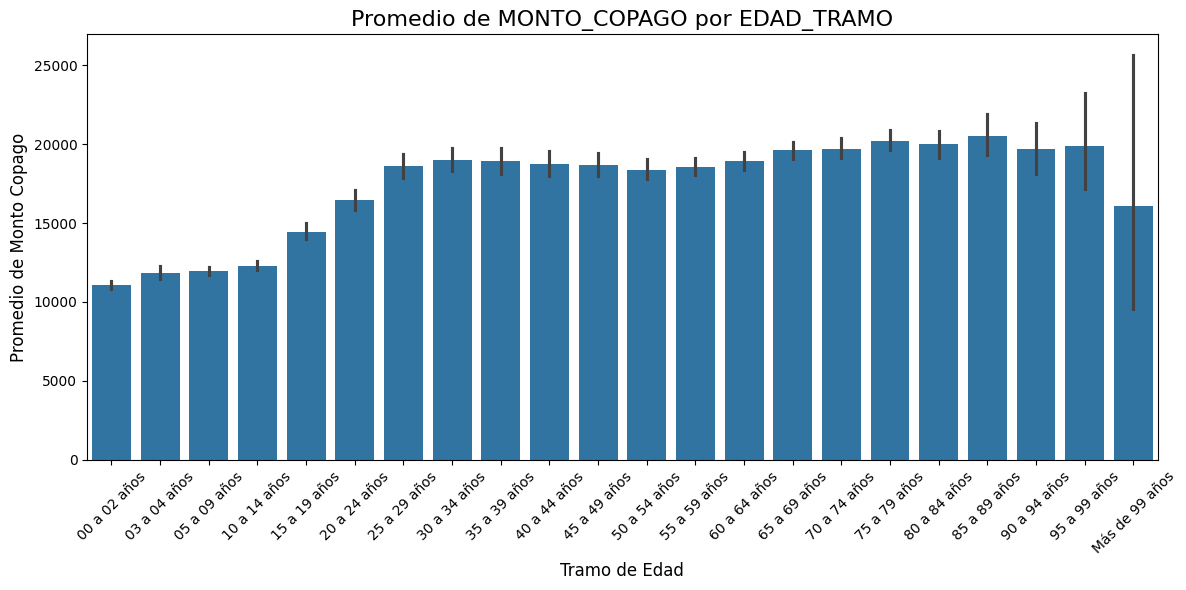

In [110]:
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mle_2023_df, 
    x="EDAD_TRAMO", 
    y="MONTO_COPAGO", 
    estimator="mean",
)

plt.title("Promedio de MONTO_COPAGO por EDAD_TRAMO", fontsize=16)
plt.xlabel("Tramo de Edad", fontsize=12)
plt.ylabel("Promedio de Monto Copago", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Analisis grafico**  
Como era de esperar, el promedio del monto de copago aumenta a medida que se incrementa la edad. En concreto, a partir de los 15-19 años se observa un aumento en el gasto medio, probablemente debido al incremento en el número de consultas realizadas por la misma persona y al mayor costo de prestaciones que no son del tipo "pediátricas".

El aumento del gasto es lineal hasta el tramo de los "90 a 94 años", desde donde comienza a disminuir, probablemente debido a una reducción en el uso de ciertos servicios médicos por parte de personas de edad avanzada.

**¿Son estos valores anteriores "correctos"?**  
Es necesario tener en cuenta:  
Por análisis previos, sabemos que en cada tramo de edad existen prestaciones significativamente más costosas, como operaciones, tratamientos o días de hospitalización, y otras más económicas, como consultas médicas o análisis de laboratorio.

Por un lado, combinar prestaciones más económicas y de mayor frecuencia con aquellas más costosas y de menor frecuencia es representativo de la realidad, ya que, aunque no todos enfrentan gastos médicos elevados, nadie está completamente exento de experimentar algún accidente, enfermedad hereditaria o consecuencias de malos hábitos. Por ende, esta "mezcla" de ambos tipos de prestaciones médicas refleja adecuadamente el espectro de costos en la vida de una persona.

Dicho lo anterior y solo con el grafico anterior
Aún no es posible si los valores son "correctos"; no solo nos interesa conocer el promedio, sino también cómo se distribuyen los valores alrededor de él, *es necesario realizar un BoxPlot*, ya que los cuartiles ayudan a detectar si existen personas con gastos excesivamente altos o bajos en comparación con la mayoría, lo que podría distorsionar los resultados.  

**Creacion de BoxPlot**  
En primer intento se busco crear el box plot con todos los valores de "MONTO_COPAGO" pero existian valores muy atipicos sobre 1 millon que dificultan la visualizacion del boxplot, por ende se calculara el IQR para analisar 2 graficos:  
1. "MONTO_COPAGO" Bajo el IQR original  
2. "MONTO_COPAGO" Sobre el IQR original

### Cuartil <Q3

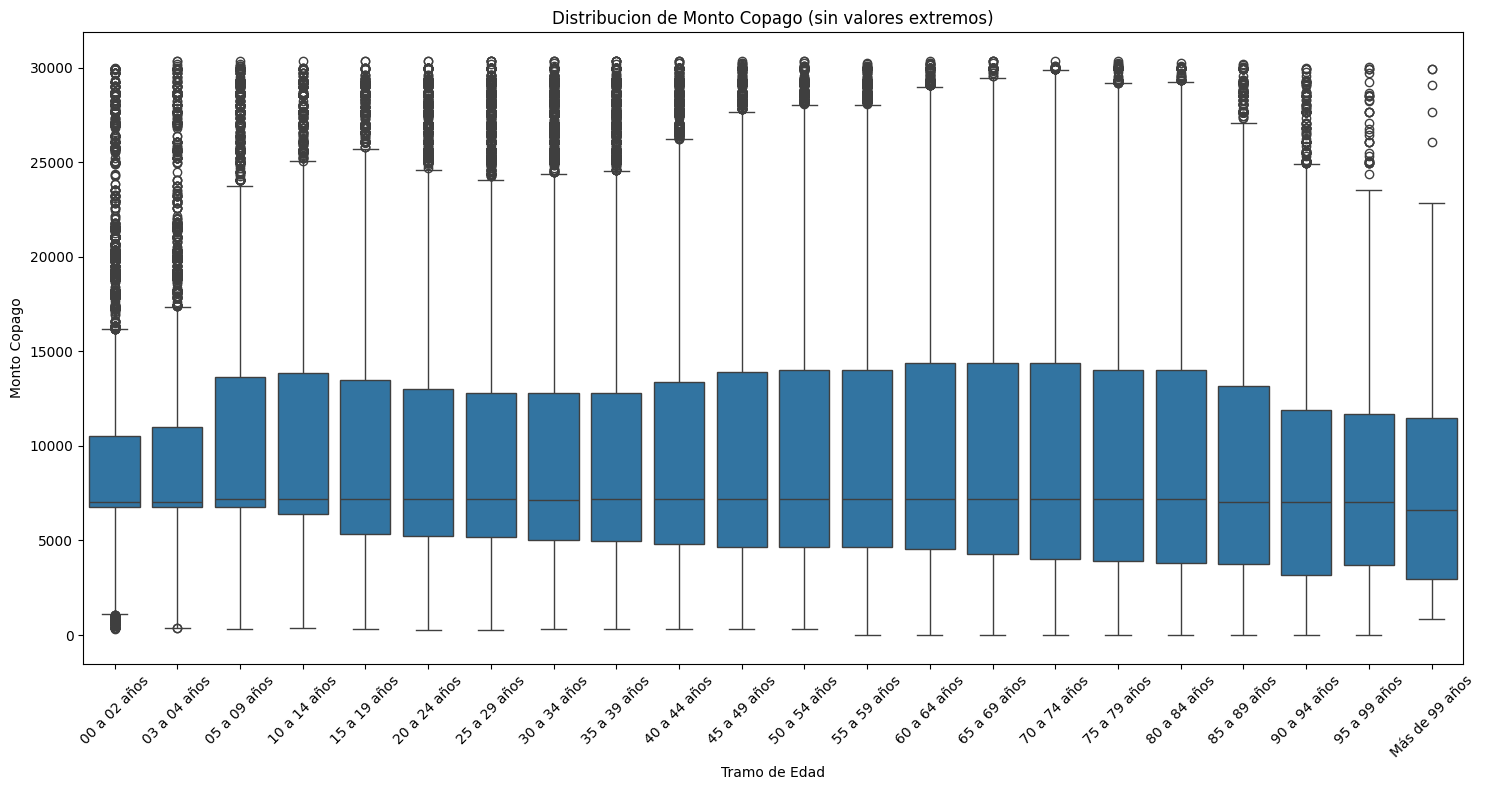

In [111]:
# Calculamos Q1, Q3 y el rango intercuartilico (IQR)
Q1 = mle_2023_df["MONTO_COPAGO"].quantile(0.25)
Q3 = mle_2023_df["MONTO_COPAGO"].quantile(0.75)
IQR = Q3 - Q1

# Asignamos limitees
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Filtrramos segun limites
benef_q3_df = mle_2023_df[(mle_2023_df["MONTO_COPAGO"] >= limite_inf) & 
                            (mle_2023_df["MONTO_COPAGO"] <= limite_sup)]
benef_q4_df = mle_2023_df[(mle_2023_df["MONTO_COPAGO"] > limite_sup)]

# Graficar
plt.figure(figsize=(15, 8))
sns.boxplot(data=benef_q3_df, x="EDAD_TRAMO", y="MONTO_COPAGO")
plt.xticks(rotation=45)
plt.title("Distribucion de Monto Copago (sin valores extremos)")
plt.xlabel("Tramo de Edad")
plt.ylabel("Monto Copago")
plt.tight_layout()
plt.show()


En el cuartil bajo el 75% tenemos el analisis de los siguientes subcuartiles (Todo con el fin de una mayor visualualizacion)  
- En Edad tramo 0 a 2 años, los copagos estan muy concentrado, su 2do y 3er cuartil es muy estrecho, alrededor 7000 pesos por copago.  
- A medida que la edad aumenta, el 3er cuartil tienden a estar menor concentrado, reflejando una mayor variedad de montos de copago y por ende, de tipos de prestaciones. Aun asi la media siempre suele estar en los 7000, he de existir una consulta medica demasiado frecuente que este ese valor, lo mas probable sea una "Consulta medica general".  
- Ahora sumando a nuestra pregunta *¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?*, se infiere que a medida que la persona tiene mayor edad, el tipo de prestacion y su copago tienden a valores mas altos, evindenciando en el 3er cuartil de los datos.


In [112]:
# Buscar "MONTO_COPAGO" mas alto
benef_q3_df.loc[benef_q3_df["MONTO_COPAGO"].idxmax()]

MES_EMISION                                                       202304
CODIGO_PRESTACIÓN                                                 306270
DESC_SECCION                                     Exámenes De Diagnóstico
DESC_ITEM                                            Laboratorio Clínico
CODIGO_BENEFICIARIO                                             97222613
TRAMO_FONASA                                                           D
EDAD_TRAMO                                                  03 a 04 años
SEXO                                                               Mujer
REGION_EMISION                                               De Coquimbo
COMUNA_EMISION                                                    Ovalle
PRESTACIONES                                                         5.0
MONTO_FAM                                                          13800
MONTO_COPAGO                                                       30350
NOMBRE_PRESTACIÓN      ANTIGENOS VIRALES DETERM. DE

### Cuartil >Q3

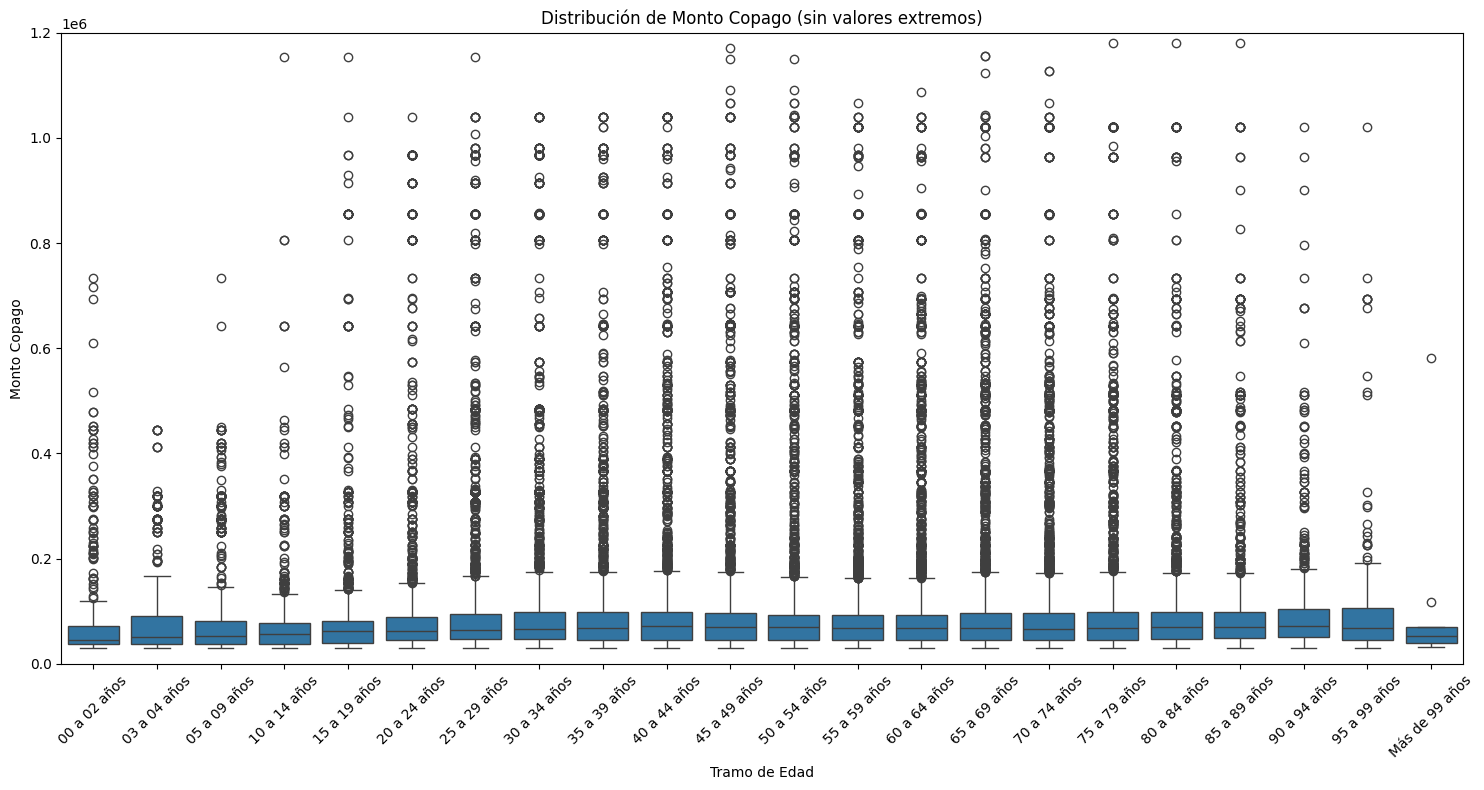

In [113]:
# Graficar
plt.figure(figsize=(15, 8))
sns.boxplot(data=benef_q4_df, x="EDAD_TRAMO", y="MONTO_COPAGO")
plt.ylim(0, 1200000)
plt.xticks(rotation=45)
plt.title("Distribución de Monto Copago (sin valores extremos)")
plt.xlabel("Tramo de Edad")
plt.ylabel("Monto Copago")
plt.tight_layout()
plt.show()

Respecto al cuartil superior al 75% de los datos, prestaciones con copago superior a 25000 pesos, los box plot suelen ser muy similares entre los "15 a 19 años" hasta los "85 a 89 años", la media esta en 60000 pesos, por otro lado los extremos aun tiene copagos mas reducidos.  
Ahora bien para responder nuestra pregunta, resulta muy interesante conocer que entre los tramos de "20 a 24 años" hasta los "75 a 79 años" las prestaciones de muy alto costo sobre los 100000 pesos, considerados valores atipicos, tienen muchos datos que si bien no se refleja en los cuartiles, si se puede ver que los datos atipicos aumentan, y por ende el inesperado gasto medico

**Ahora, crearemos un histograma para cada tramo de edad, donde:**  
- Eje x: "MONTO_COPAGO"  
- Eje y: Frecuencia de prestaciones

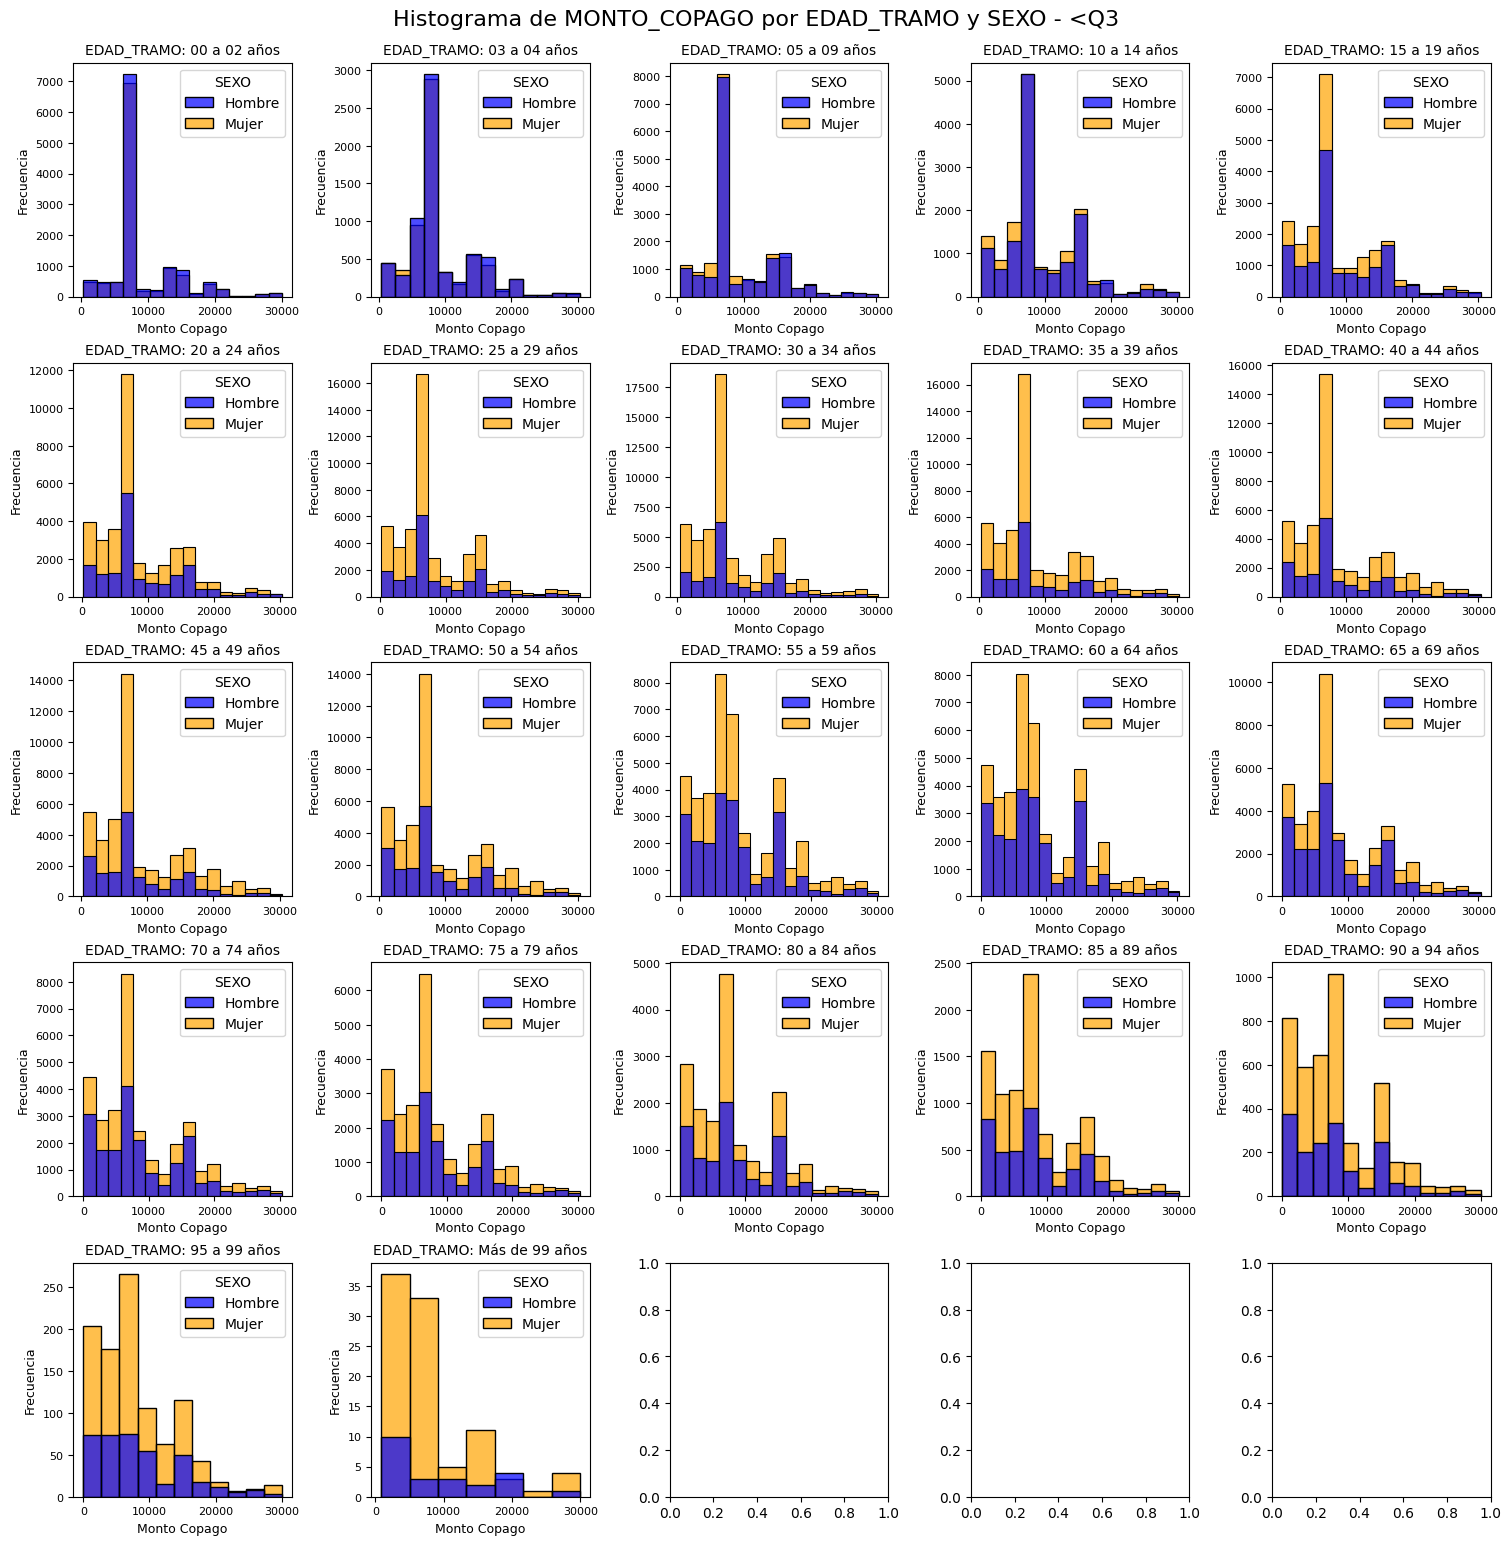

In [114]:
edad_tramos = benef_q3_df["EDAD_TRAMO"].unique()

# Config de la cuadricula de subplots
num_tramos = len(edad_tramos)
cols = 5
rows = int(np.ceil(num_tramos / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten()

# Iterar por cada tramo de edad
for i, tramo in enumerate(edad_tramos):
    datos_tramo = benef_q3_df[benef_q3_df["EDAD_TRAMO"] == tramo]
    
    if len(datos_tramo) > 0:
        # bins segun regla de sturges en log2
        nbins = max(1, int(np.log2(len(datos_tramo)) + 1))
        color_palette = {"Hombre": "blue", "Mujer": "orange"}
        hue_order = ["Hombre", "Mujer"]

        # histograma con hue = "SEXO"
        sns.histplot(
            data=datos_tramo,
            x="MONTO_COPAGO",
            hue="SEXO",
            bins=nbins,
            ax=axes[i],
            kde=False,
            hue_order=hue_order,
            palette=color_palette,
            edgecolor="black",
            alpha=0.7
        )
        
        # Personalizar
        axes[i].set_title(f"EDAD_TRAMO: {tramo}", fontsize=10)
        axes[i].set_xlabel("Monto Copago", fontsize=9)
        axes[i].set_ylabel("Frecuencia", fontsize=9)
        axes[i].tick_params(axis="x", labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)
    else:
        axes[i].axis("off")

fig.suptitle("Histograma de MONTO_COPAGO por EDAD_TRAMO y SEXO - <Q3", fontsize=16, y=1.02)
plt.show()

Al entrar en detalle del histograma segun "TRAMO_EDAD" podemos confirmar las conclusiones del boxplot:  
- La media suele estar en 7000
- A medida que aumenta la edad, la frecuecia de prestaciones de mayor valor aumenta
- Las prestaciones alrededor de 15000, aumentan constantemente a medida que el tramo de edad aumenta, hasta llegar a los 85 a 80 años

- Con la nueva variable "SEXO" agregada al HUE, podemos decir que las prestaciones totales para mujeres es casi el doble que de hombres.

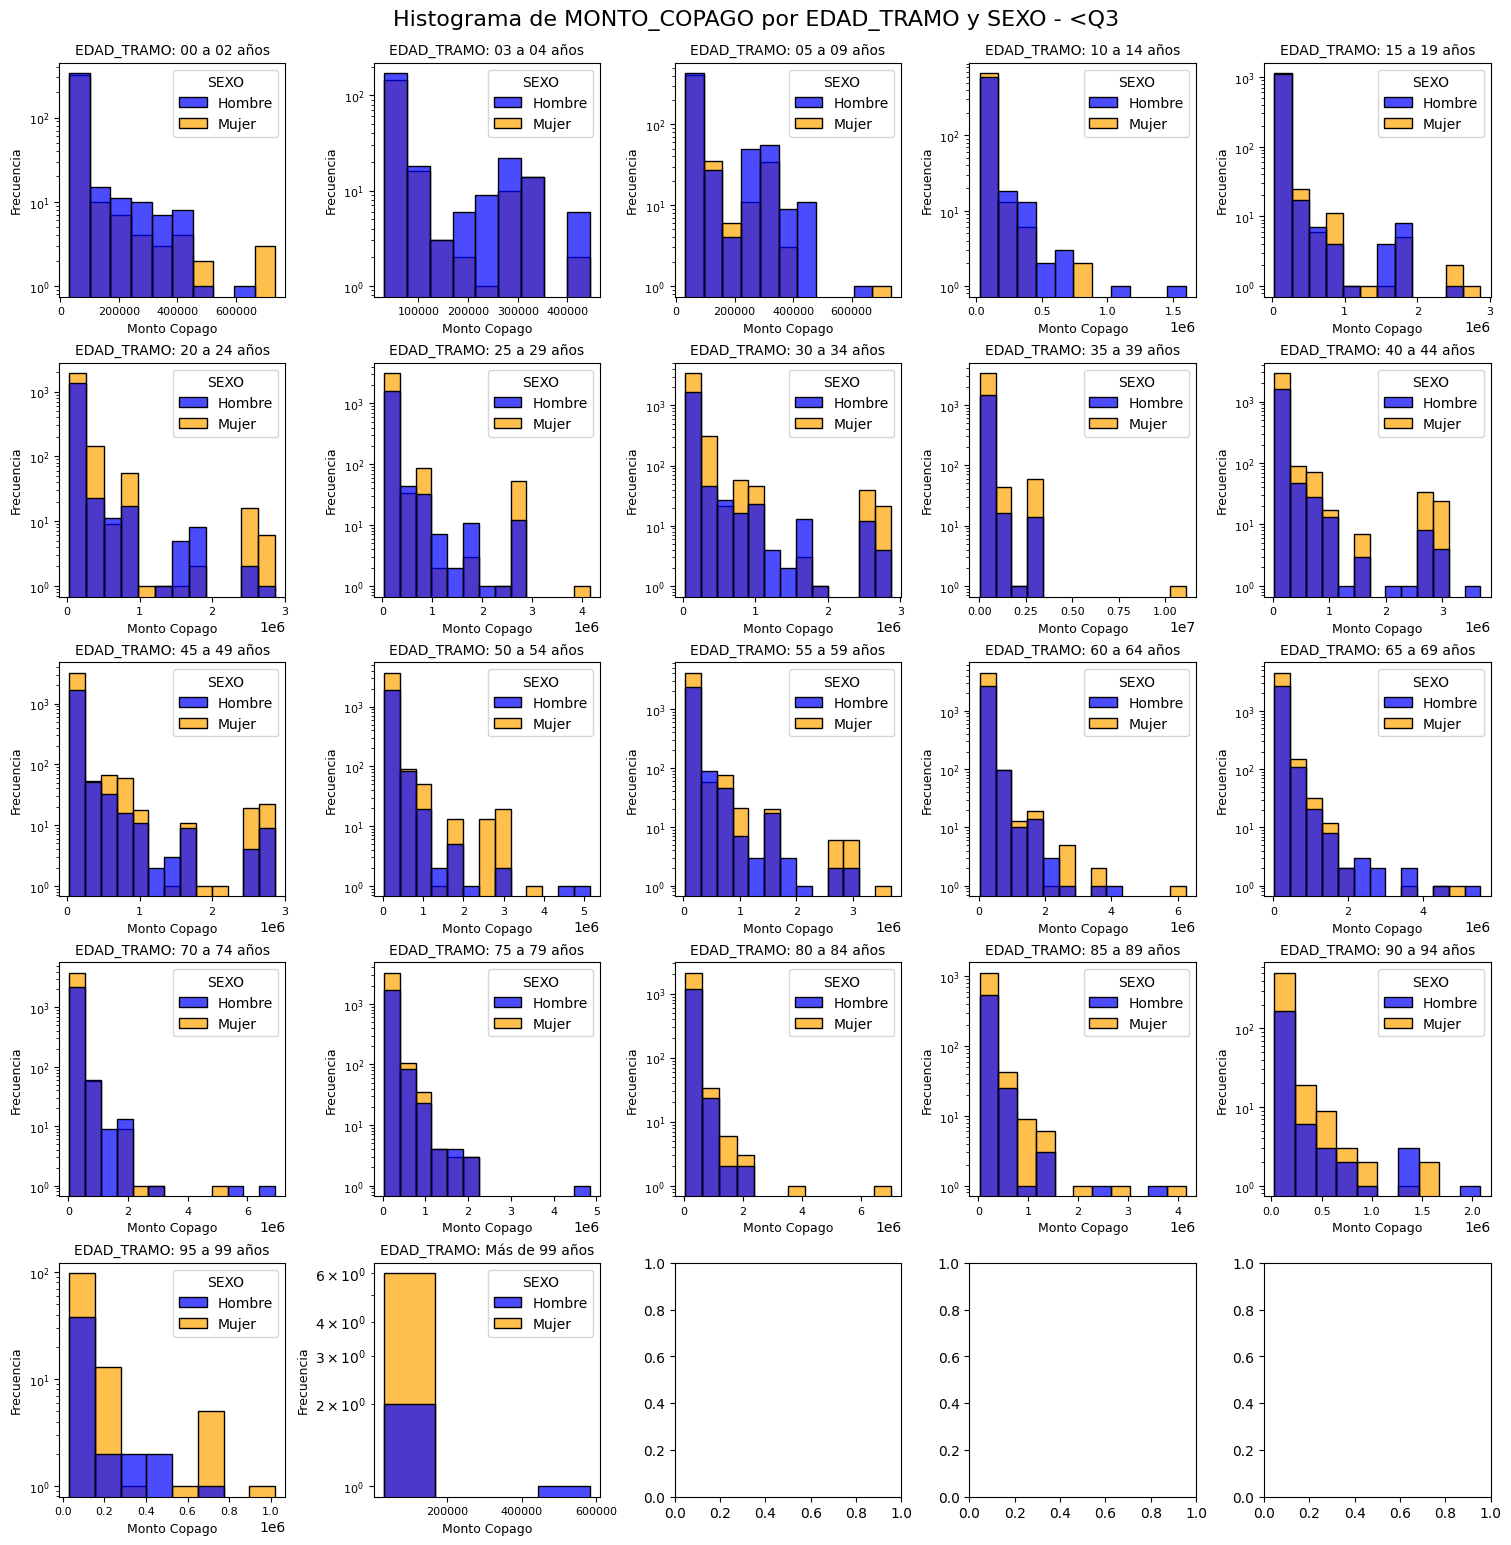

In [115]:
# lo mismo de arriba
edad_tramos = benef_q4_df["EDAD_TRAMO"].unique()

num_tramos = len(edad_tramos)
cols = 5
rows = int(np.ceil(num_tramos / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten()

for i, tramo in enumerate(edad_tramos):
    datos_tramo = benef_q4_df[benef_q4_df["EDAD_TRAMO"] == tramo]
    
    if len(datos_tramo) > 0:
        nbins = max(1, int(np.log2(len(datos_tramo)) + 1))
        color_palette = {"Hombre": "blue", "Mujer": "orange"}
        hue_order = ["Hombre", "Mujer"]

        sns.histplot(
            data=datos_tramo,
            x="MONTO_COPAGO",
            hue="SEXO",
            bins=nbins,
            ax=axes[i],
            kde=False,
            hue_order=hue_order,
            palette=color_palette,
            edgecolor="black",
            alpha=0.7
        )

        # Usaremos escala logaritmica dada la poca frecuencia de los valores altos
        axes[i].set_yscale("log")
        
        axes[i].set_title(f"EDAD_TRAMO: {tramo}", fontsize=10)
        axes[i].set_xlabel("Monto Copago", fontsize=9)
        axes[i].set_ylabel("Frecuencia", fontsize=9)
        axes[i].tick_params(axis="x", labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)
    else:
        axes[i].axis("off")

fig.suptitle("Histograma de MONTO_COPAGO por EDAD_TRAMO y SEXO - <Q3", fontsize=16, y=1.02)
plt.show()

Al analizar el cuartil superior a q3, y utilizando una escala logaritmica vemos que el numero de prestaciones de muy alto valor empiezan a ser mas frecuente a mayor "edad_tramo" de las personas.  
He de notar que las prestaciones de alto valor entre hombre y mujeres parece equiparse en estos tramos de costo.

### Conclusion

**¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?**  
En base a los 3 tipos de analisas hechos: Frecuencia, boxplot e histogramas para cada tramo de edad. Podemos responder que El gasto promedio aumenta por dos motivos. El mayor numero de frecuencia de prestaciones medicas emitidas por persona a medida que aumenta la edad, generando una campana de gauss con valores bajos en edades cercanas a 0 - 10 años y para 80-100+ años.  

El tipo de prestaciones medicas usadas son mas caras en si, el valor promedio de cada prestacion aumenta con la edad, debido a naturalmente la consulta, operaciones, tratamiento de enfermedades mas propensas en edades mas avanzadas, esto es especialmente notables con operaciones de muy alto coste que suelen ser mas frecuente en edades intermedias hasta avanzadas 30-80 años, pero curiosamente en edades sobre 80 años baja.  

El gasto medico, aumenta linealmente con la edad hasta probablemente el fallecimiento de la persona, y baja sobre los 80 años meramente por la menor cantidad de personas que supera dicha edad.

## **MODELAMIENTO**

### Justificacion del modelo

Se utilizara una regresion lineal simple, ya que creemos que la relación entre las variables "total1" (variable independiente) y "bene1" (variable dependiente) es es aproximadamente lineal, a continuacion describiremos tabla y atributos:  

El dataframe utilizado es "~presupuestos_fonasa", el cual contiene todos los prepuestos para los distintos tramos de fonasa, en este caso trabajaremos en el tramo B (recordar que tramo A, no tiene beneficios en MLE).  
- "total1" es un monto en pesos que figura el arancel fijo de una prestacion medica para todos los centros medicos, el monton bruto, sin beneficios.
- "bene1" es el valor real que el usuario debe pagar, el descuento es cobrado al prestador de salud, en este caso FONASA.  

Lo que buscamos es predecir el valor "bene1" dado un "total1", dado que el sistema de salud siempre esta en evolucion, el asignar nuevos valores de copago para nuevas prestaciones medicas es necesario, para ello podemos utilizar informacion pasada para reconocer los patrones de asignacion.


In [116]:
presupuestos_df = pd.read_csv("../data/Presupuestos_MLE_2023_original_limpio.csv", encoding="latin1")

In [117]:
presupuestos_df.columns

Index(['secuencia', 'grupo', 'sub_grupo', 'presta', 'corr', 'titulo', 'anes1',
       'anesben1', 'anes2', 'anesben2', 'anes3', 'anesben3', 'equipo', 'pab',
       'NOMBRE_PRESTACIÓN', 'total1', 'bene1', 'total2', 'bene2', 'total3',
       'bene3', 'valcir11', 'valcir12', 'valcir13', 'valcir21', 'valcir22',
       'valcir23', 'valcir31', 'valcir32', 'valcir33', 'valcir41', 'valcir42',
       'valcir43', 'CODIGO_PRESTACIÓN'],
      dtype='object')

In [118]:
presupuestos_df.sample(10)

,secuencia,grupo,sub_grupo,presta,corr,titulo,anes1,anesben1,anes2,anesben2,...,valcir21,valcir22,valcir23,valcir31,valcir32,valcir33,valcir41,valcir42,valcir43,CODIGO_PRESTACIÓN
2309,3995,25,1,41,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2501041
253,370,3,3,6,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,303006
2241,3921,24,1,26,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2401026
1160,1986,13,2,42,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1302042
927,1593,11,3,30,0,5,77500,38750,100750,62000,...,60110,78144,96176,0,0,0,0,0,0,1103030
456,716,3,6,85,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,306085
2281,3965,25,1,2,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2501002
1708,3000,18,2,77,0,5,54670,27340,71070,43740,...,46020,59826,73632,0,0,0,0,0,0,1802077
2344,4034,25,2,11,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2502011
1846,3242,19,2,83,0,5,39710,19860,51620,31770,...,29358,38166,46972,0,0,0,0,0,0,1902083


In [119]:
presupuestos_df

,secuencia,grupo,sub_grupo,presta,corr,titulo,anes1,anesben1,anes2,anesben2,...,valcir21,valcir22,valcir23,valcir31,valcir32,valcir33,valcir41,valcir42,valcir43,CODIGO_PRESTACIÓN
0,31,1,1,1,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101001
1,32,1,1,201,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101201
2,33,1,1,202,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101202
3,34,1,1,203,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101203
4,35,1,1,204,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,4191,29,4,14,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2904014
2423,4192,29,4,15,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2904015
2424,4193,29,4,16,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2904016
2425,4194,29,4,17,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2904017


In [120]:
# Alivianar la carga de trabajo
presupuestos_df = presupuestos_df[["NOMBRE_PRESTACIÓN", "total1", "bene1", "total2", "bene2", "total3", "bene3"]]

**Trabajaremos con montos_totales bajo 1 millon de pesos...**  
Dado que la asignacion de prepuestos para prestaciones de alto costo, deberia ser una desicion humana y con cierto criterio etico.

In [121]:
presupuestos_acot_df = presupuestos_df[presupuestos_df["total1"] <= 1000000]

<Axes: >

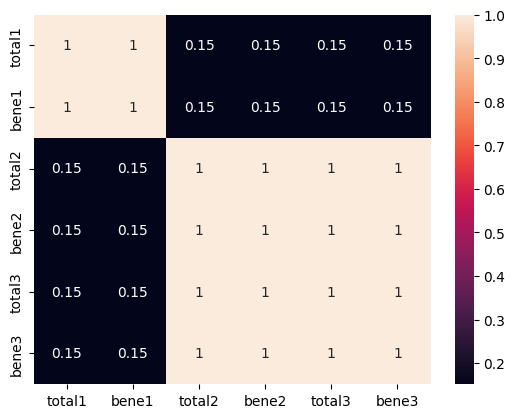

In [122]:
sns.heatmap(presupuestos_df.corr(numeric_only=True), annot=True)

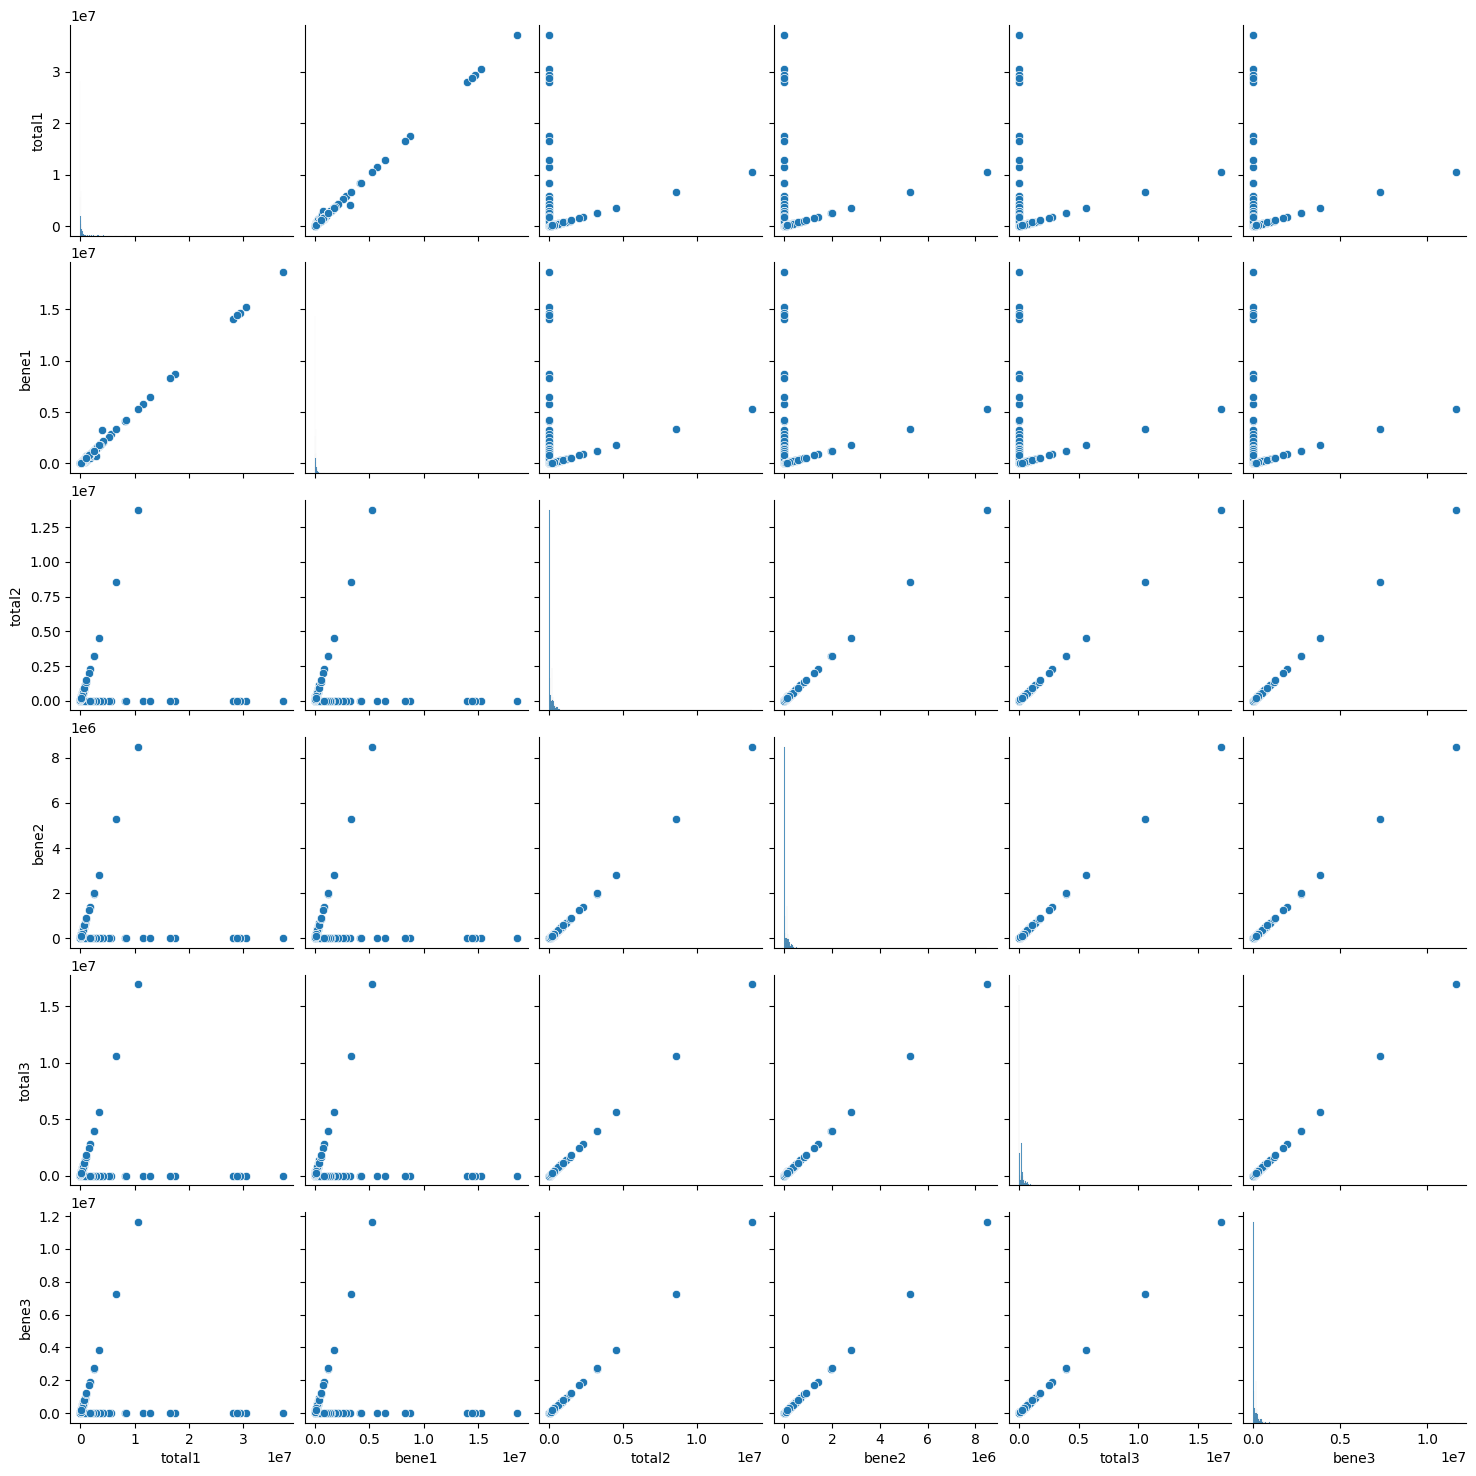

In [123]:
sns.pairplot(presupuestos_df)

Parece existir una correlacion perfecta entre nuestras variables... Es motivo de decepcion? para nada, vamos a conocer un modelamiento perfecto que revelara en el mejor de los casos y salvo valores atipicos el porcentaje de descuento asignado por fonasa a cada tramo, informacion que no es difundida y que a simple vista y sin conocer todos los datos, seria dificil de intuir.  
**Vamos a continuar...**

### La Regresion Lineal

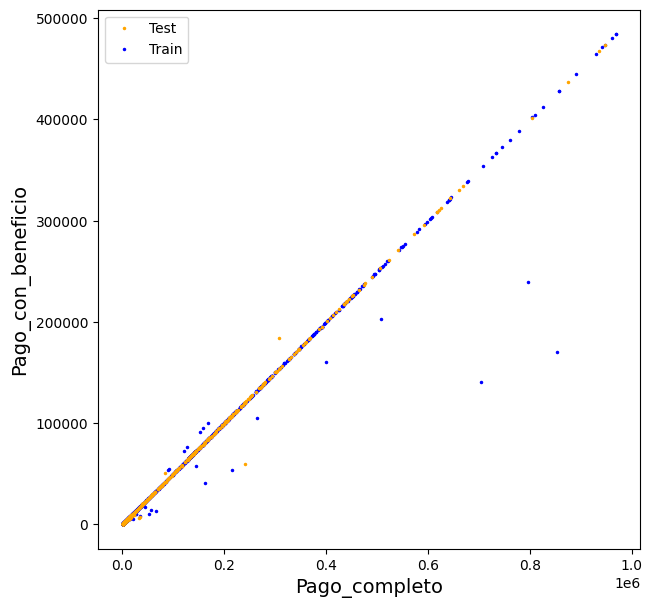

In [124]:
# Separar df para datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
train, test = train_test_split(presupuestos_acot_df, test_size=0.25, random_state=2)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.plot(test["total1"], test["bene1"], ".", markersize=3, color="orange", zorder=1, label="Test")
plt.plot(train["total1"], train["bene1"], ".", markersize=3, color="blue", zorder=0, label="Train")
ax.set_xlabel("Pago_completo",fontsize=14)
ax.set_ylabel("Pago_con_beneficio",fontsize=14)
ax.legend()

En primera instancia podemos ver la perfecta correlacion, descrita anteriormente.

In [125]:
# Ajustamos para usar sklearn
y_train = np.array(train["bene1"])
y_test = np.array(test["bene1"])

X_train = np.array(train["total1"])
X_train = X_train.reshape(X_train.shape[0], 1) # Un arreglo 2D, una columna muchas filas
X_test = np.array(test["total1"])
X_test = X_test.reshape(X_test.shape[0], 1)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linreg = LinearRegression()
linreg.fit(X_train, y_train) # Aqui aprende

# calculo de funcionamiento
y_pred_train = linreg.predict(X_train)
r2_lineal_train = linreg.score(X_train, y_train)
rmse_train = mean_squared_error(y_train, y_pred_train)

print("\nMétricas de Entrenamiento")
print(f"r^2 : {r2_lineal_train}") # R² o coeficiente de determinación -> 1 es mejor
print(f"RMSE {rmse_train}") # Raíz del error cuadrático medio (distancia punto a la linea) -> 0 es mejor
print(f"Coeficientes: {linreg.coef_[0], linreg.intercept_}") # Pendiente y cruce eje y

#predecir valores de y para el set de prueba
y_pred_test = linreg.predict(X_test)
r2_lineal_test = linreg.score(X_test, y_test)
rmse_test = mean_squared_error(y_test, y_pred_test)

print("\nMétricas de Prueba")
print(f"r^2 : {r2_lineal_test}")
print(f"RMSE {rmse_test}")



Métricas de Entrenamiento
r^2 : 0.9857414269255609
RMSE 80788876.07357095
Coeficientes: (np.float64(0.4892123414341468), np.float64(765.0676201920578))

Métricas de Prueba
r^2 : 0.9979559974049224
RMSE 11068985.425669638


**Metricas de Entrenamiento**  
R² (coeficiente de determinacion): 0.9857  
Esto indica que el modelo explica el 98.57% de la variabilidad en "bene1" usando "total1". Es un ajuste excelente.  

RMSE (error cuadratico medio): 80,788,876.07  
Aunque el valor absoluto parece alto, las magnitudes de los datos son grandes.  

Coeficientes:  
Intercepto: 765.0676  
Pendiente: 0.4892. Esto indica que por cada peso que aumenta "total1", "bene1" aumenta en aproximadamente 0.489 pesos.

**Metricas de Prueba**  
R²: 0.9979  
Similar al entrenamiento, el modelo tiene un ajuste excelente en los datos de prueba, explicando el 99.79% de la variabilidad.  

RMSE: 11,068,985.43  
El error en los datos de prueba es mucho menor que en el entrenamiento, lo cual indica un buen rendimiento.

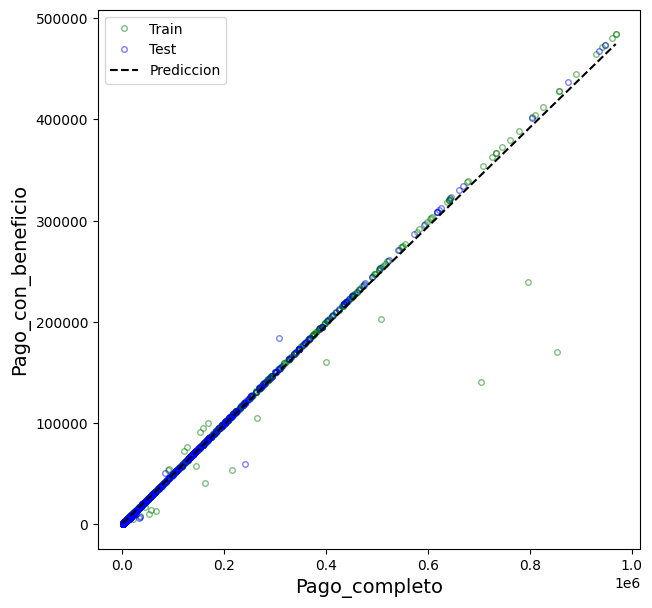

In [126]:
# Graficar - Regresion Lineal
fig1, ax = plt.subplots(1,1, figsize=(7,7))

ax.plot(train["total1"], train["bene1"],"o", markersize=4, mec="green", mfc="None", label="Train", alpha=0.5) 
ax.plot(test["total1"], test["bene1"],"o", markersize=4, mec="blue", mfc="None", label="Test", alpha=0.5) 

xgrid = np.linspace(np.min(train["total1"]), np.max(train["total1"]), 100)
ax.plot(xgrid, linreg.predict(xgrid.reshape(100, 1)), label="Prediccion", color="k", ls="--")
ax.set_xlabel("Pago_completo", fontsize=14)
ax.set_ylabel("Pago_con_beneficio", fontsize=14)
ax.legend()

**Ahora vamos a probarlo en vivo...**  
La funcion predecir_beneficio(). Predice el valor de 'bene1' dado un 'total1' usando el modelo entrenado  

Parametros:  
- total1_input: Valor de 'total1' para predecir  
- modelo: Modelo de regresión entrenado  

Retorna:  
- Prediccion de 'bene1'  

In [127]:
def predecir_beneficio(total1_input, modelo):
    total1_array = np.array([[total1_input]])
    bene1_pred = modelo.predict(total1_array)
    return bene1_pred[0]

# Solicita un valor de entrada y predice

while True:
    try:
        total1_input = float(input("Ingresa un valor para 'total1' (o escribe 'salir' para terminar): "))
        prediccion = predecir_beneficio(total1_input, linreg)
        print(f"Para un 'total1' de {total1_input}, el modelo predice un 'bene1' de {prediccion:.2f}")
    except ValueError:
        print("Entrada inválida. Asegúrate de ingresar un número o 'salir' para terminar.")
        break

Entrada inválida. Asegúrate de ingresar un número o 'salir' para terminar.


**Resultados**  
El modelamiento es perfecto y es util, ahora puede conocer el monto copago para nuevas prestaciones medicas, y si quieres corroborar en caso que te cobren mal una prestacion.  

## **IV - Conclusión**

Para concluir responderemos nuestra pregunta general:  

**¿Cómo varían las necesidades de atención médica y el gasto asociado en la población chilena según factores demográficos, socioeconómicos y geográficos?**

El analisis revela que las necesidades de atencion medica y los gastos asociados en la poblacion chilena estan profundamente influenciados por factores demograficos, socioeconomicos y geograficos:  

**Factores demograficos:**  
Edad: Las prestaciones medicas varian segun el rango etario. En la infancia, predominan consultas generales y pediatricas, mientras que en la adolescencia se observa un aumento en prestaciones relacionadas con la salud mental. En los adultos y adultos mayores, las atenciones se enfocan en chequeos generales, diagnosticos especializados y tratamientos de enfermedades cronicas, con un aumento del gasto promedio en copagos conforme avanza la edad.  

Genero: Las mujeres acceden a mas prestaciones que los hombres, con una alta demanda en salud reproductiva y obstetricia. Por otro lado, ciertas prestaciones como las pediatricas son mas frecuentes en niños varones, posiblemente por factores culturales o biologicos.  

**Factores socioeconomicos:**  
Tramos de Fonasa: Las prestaciones mas comunes, como examenes diagnosticos y consultas generales, son recurrentes en todos los tramos de ingreso, reflejando necesidades basicas de salud. Sin embargo, las diferencias en los tipos de prestaciones utilizadas pueden estar vinculadas a los recursos disponibles y la capacidad de pago en cada tramo.  

**Factores geograficos:**  
Regiones: Existen marcadas disparidades regionales en la frecuencia y el tipo de prestaciones medicas. Las zonas urbanas, como la Region Metropolitana, concentran la mayor cantidad de atenciones, mientras que regiones mas alejadas presentan una demanda menor, probablemente debido a barreras de acceso y disponibilidad de infraestructura sanitaria.  

**Gasto medico:**  
El gasto promedio en copagos aumenta con la edad, principalmente debido a la mayor frecuencia y complejidad de las prestaciones requeridas en etapas avanzadas de la vida. Sin embargo, en edades superiores a los 80 años, el gasto disminuye, posiblemente por una menor poblacion en este rango etario y un cambio en los patrones de atencion medica.  

**Conclusion:**  

La variabilidad en las necesidades y el gasto en atencion medica refleja la interaccion de multiples factores. Las diferencias demograficas y socioeconomicas destacan la importancia de la edad, genero y capacidad de pago, mientras que las desigualdades geograficas subrayan la necesidad de politicas publicas que aborden las brechas en acceso y calidad de los servicios de salud.

### **ETICA**

**Limitaciones y sesgos de los datos:**  

Regiones con menor población o acceso a servicios de salud podrían estar subrepresentadas, sesgando los resultados hacia las zonas urbanas con más datos disponibles.  

Sesgo en la representación de grupos vulnerables, grupos como poblaciones rurales, adultos mayores o personas con discapacidades podrían estar infrarepresentados, afectando la capacidad de identificar sus necesidades específicas.  

Sesgo en el registro de prestaciones, las prestaciones registradas podrían no reflejar el total de necesidades médicas, ya que muchas personas podrían no buscar atención médica debido a barreras económicas, culturales o de acceso.  

Suposición de homogeneidad dentro de los tramos de Fonasa, asumir que las personas en un mismo tramo de Fonasa tienen comportamientos o necesidades homogéneas puede simplificar excesivamente el análisis y ocultar diferencias importantes.  

**Posibles problemas derivados del análisis o decisiones basadas en él:**

Recomendaciones mal enfocadas, si las decisiones políticas o de recursos se basan únicamente en los resultados del análisis, podrían ignorar necesidades no capturadas en los datos (por ejemplo, enfermedades subdiagnosticadas o barreras culturales).

Exacerbación de desigualdades, políticas que prioricen áreas o grupos con mayor demanda registrada podrían perpetuar desigualdades al ignorar regiones o poblaciones con barreras de acceso al sistema de salud.

Predicciones inexactas en poblaciones pequeñas, modelos de predicción basados en regresión lineal podrían no captar patrones complejos o no lineales, especialmente en subpoblaciones pequeñas o grupos con comportamientos atípicos.

Foco excesivo en el gasto médico, centrarse en el gasto promedio por edad podría llevar a priorizar intervenciones basadas en costos en lugar de necesidades médicas, descuidando la calidad de la atención.